<a href="https://colab.research.google.com/github/HammadN98/Desafio_LightHouse/blob/main/LH_CD_NIMERPERUZZIHAMMAD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.3.2

Found existing installation: scikit-learn 1.3.2
Uninstalling scikit-learn-1.3.2:
  Successfully uninstalled scikit-learn-1.3.2
  Using cached scikit_learn-1.3.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.3.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.9 MB)


# Analise do mercado de aluguies temporarios em NYC

**Objetivo**: Prever valores de acomodacoes

Perguntas de negocio:

1. Supondo que uma pessoa esteja pensando em investir em um apartamento para alugar na plataforma, onde seria mais indicada a compra?
2. O número mínimo de noites e a disponibilidade ao longo do ano interferem no preço?
3. Existe algum padrão no texto do nome do local para lugares de mais alto valor?


## 0. Importacoes

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder


sns.set_style("dark")

In [3]:
path2 = "C:\\Users\\Nimer\\desafio\\dados\\teste_indicium_precificacao.csv"
path = "https://raw.githubusercontent.com/HammadN98/Desafio_LightHouse/refs/heads/main/dados/teste_indicium_precificacao.csv"
dados = pd.read_csv(path)
#dados_backup = dados

In [4]:
def cria_describe_boxplot_hist(dados: pd.DataFrame, coluna: str, filtro: str = None):
  """Funcao para rodar a primeiras informacoes estatistidas dos dados."""
  print(dados[coluna].describe())

  fig, axes = plt.subplots(1, 2, figsize=(16, 6))

  sns.boxplot(dados[coluna], ax=axes[0])
  axes[0].set_title(f'Boxplot de {coluna}')
  if filtro:
    dados_filtro = dados.query(filtro)
    sns.histplot(dados_filtro[coluna], bins=50, kde=True, ax=axes[1])
  else:
    sns.histplot(dados[coluna], bins=50, kde=True, ax=axes[1])
  axes[1].set_title(f'Histograma e KDE de {coluna}')

  plt.tight_layout()
  plt.show()

In [5]:
def cria_barplot(dados: pd.DataFrame, eixo_x: str, eixo_y:str, hue:str):
  """ Funcao para criar os graficos de barra de maneira padrao"""
  plt.figure(figsize=(8, 6))
  sns.barplot(x=eixo_x, y=eixo_y, data=dados, hue=hue)
  plt.title(f'{eixo_x} por {eixo_y}', fontsize=16)
  plt.ylabel(' ', fontsize=14)
  plt.xlabel(' ', fontsize=14)
  plt.xticks(rotation=45)

  plt.show()

In [6]:
def cria_boxplot(dados: pd.DataFrame, eixo_x:str, eixo_y :str, hue :str, y_lim:int = None):
  plt.figure(figsize=(8, 6))
  sns.boxplot(data=dados, x=eixo_x, y=eixo_y, hue=hue)
  plt.title(f'Distribuição de {eixo_x} por {eixo_y}', fontsize=16)
  plt.xlabel('', fontsize=14)
  plt.ylabel('', fontsize=14)
  plt.ylim(0, y_lim)
  plt.show()

In [7]:
def cria_scatterplot(dados:pd.DataFrame, eixo_x:str, eixo_y:str, c= None, alpha:int = 0.5):
  plt.figure(figsize=(8, 6))
  sns.scatterplot(x=eixo_x, y=eixo_y, data=dados, alpha=alpha, c = None) #mudar para relacionados com price
  plt.title(f'Relacao {eixo_x} com {eixo_y} ', fontsize=16)
  plt.xlabel(' ', fontsize=14)
  plt.ylabel(' ', fontsize=14)
  plt.show()


In [8]:
def cria_barh(filtro, titulo):
  plt.figure(figsize=(8, 6))
  sns.barplot(x=filtro.values, y=filtro.index)
  plt.title(f'{titulo}', fontsize=16)
  plt.xlabel('Quantidade', fontsize=14)
  plt.ylabel(f' ', fontsize=14)
  plt.show()

In [9]:
def cria_dist_geo(dados: pd.DataFrame, coluna:str):

  plt.figure(figsize=(8, 6))
  cores = sns.color_palette('Set1', n_colors=dados[coluna].nunique()) #config as cores
  categorias = dados[coluna].unique()

  for i, categoria in enumerate(categorias):
        subset = dados[dados[coluna] == categoria]
        plt.scatter(
            subset['longitude'],
            subset['latitude'],
            alpha=0.5,
            s=10,
            label=categoria,
            color=cores[i]
        )

  plt.title(f'Distribuição Geográfica por {coluna}', fontsize=16)
  plt.xlabel('Longitude', fontsize=14)
  plt.ylabel('Latitude', fontsize=14)
  plt.legend(title=f'{coluna}')
  plt.grid(True, alpha=0.5)
  plt.show()


In [10]:
def plot_boxplots(df, colunas):
    """Gera um boxplot para cada coluna"""
    plt.figure(figsize=(12, len(colunas) * 4))

    for i, coluna in enumerate(colunas, 1):
        plt.subplot(len(colunas), 1, i)
        sns.boxplot(x=df[coluna], color='royalblue')
        plt.title(f'Boxplot de {coluna}')
        plt.xlabel(coluna)

    plt.tight_layout()
    plt.show()

## 1. Estatisticas basicas: Primeiro contato com os dados

In [11]:
dados.head(5)

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


In [12]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             48894 non-null  int64  
 1   nome                           48878 non-null  object 
 2   host_id                        48894 non-null  int64  
 3   host_name                      48873 non-null  object 
 4   bairro_group                   48894 non-null  object 
 5   bairro                         48894 non-null  object 
 6   latitude                       48894 non-null  float64
 7   longitude                      48894 non-null  float64
 8   room_type                      48894 non-null  object 
 9   price                          48894 non-null  int64  
 10  minimo_noites                  48894 non-null  int64  
 11  numero_de_reviews              48894 non-null  int64  
 12  ultima_review                  38842 non-null 

Apenas "ultima_review" e "reviews_por_mes", tem uma alta quantidade de variáveis nulas. Por hora irei removê-las para trabalhar com apenas dados completos, já que mesmo excluindo nulos teremos 38800 registros. Porém, se ao longo da análise acharmos pertinente retornar com os dados completos, e imputar a quantidade faltante com alguma medida de posição, assim o faremos, iremos avaliar o quanto estas variáveis impactam no modelo.

Como cliente sabemos que principalmente "última review" traz segurança do estado do local a ser alugado. Bem como “reviews_por_mes”, talvez não tanto quanto a primeira.

In [13]:
dados.describe()

,id,host_id,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
count,4.889400e+04,4.889400e+04,48894.000000,48894.000000,48894.000000,48894.000000,48894.000000,38842.000000,48894.000000,48894.000000
mean,1.901753e+07,6.762139e+07,40.728951,-73.952169,152.720763,7.030085,23.274758,1.373251,7.144005,112.776169
std,1.098288e+07,7.861118e+07,0.054529,0.046157,240.156625,20.510741,44.550991,1.680453,32.952855,131.618692
min,2.595000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.472371e+06,7.822737e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967743e+07,3.079553e+07,40.723075,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915225e+07,1.074344e+08,40.763117,-73.936273,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


Primeira impressão sobre as variáveis:


1. price
    * Média muito abaixo do valor máximo, outlier? Ou um local muito luxuoso?
    * Local com 0 dólares de preço, e gratuito? Erro?
    * Dp está sendo influenciado pelos valores outliers? Ou temos locais para todo tipo de cliente?
    * Os quartéis parecem estáveis, desconsiderando a explosão no max.
2. minimo_noites
    * A média também está muito abaixo do valor máximo. Reflete o comportamento de Price, Erros? ou luxo?
    * Dp possivelmente influenciado pelo valor máximo, já que os quartis estão com valores semelhantes.
3. numero_de_reviews
    * Comportamento extremamente semelhante a Price e Mínimo de noite
4. Reviews por mês
    * O valor 0.01 em mínimo se refere a taxa de reviews? Ou foi erro de entrada? Ademais, o comportamento segue o padrão de price.
5. calculado_host_listings_count
    * Comportamento extremamente semelhante a price, minimo_noites e Numero_de_reviews
6. Disponibilidade_365
    * Por qual motivo tem anúncio com a disponibilidade de 0? Qual seria a necessidade de manter anúncio de um local que não pode ser alocado? Verificar a quantidade de registro assim, e verificar se a existência da variável não irá prejudicar o modelo. Posso fazer alguma transformação para a variável ser útil? De resto mantém o comportamento das outras variáveis.


**Considerações finais:** Todos estão com outliers nos valores máximos? Ou é de fato o comportamento dos dados?
Próximo passo -> Avaliar variável por variável e entender o comportamento dos outliers em valores máximo.


## 2. Análise Exploratória dos dados


Aqui iremos separar a análise em duas: Variáveis numéricas e variáveis categóricas.


### 2.1 Variaveis Numericas

1. price -> Alvo
2. minimo_noites
3. numero_de_reviews
4. reviews_por_mes
5. calculado_host_listings_count
6. disponibilidade_365
7. ultima_review

#### 2.1.1 price

count    48894.000000
mean       152.720763
std        240.156625
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64


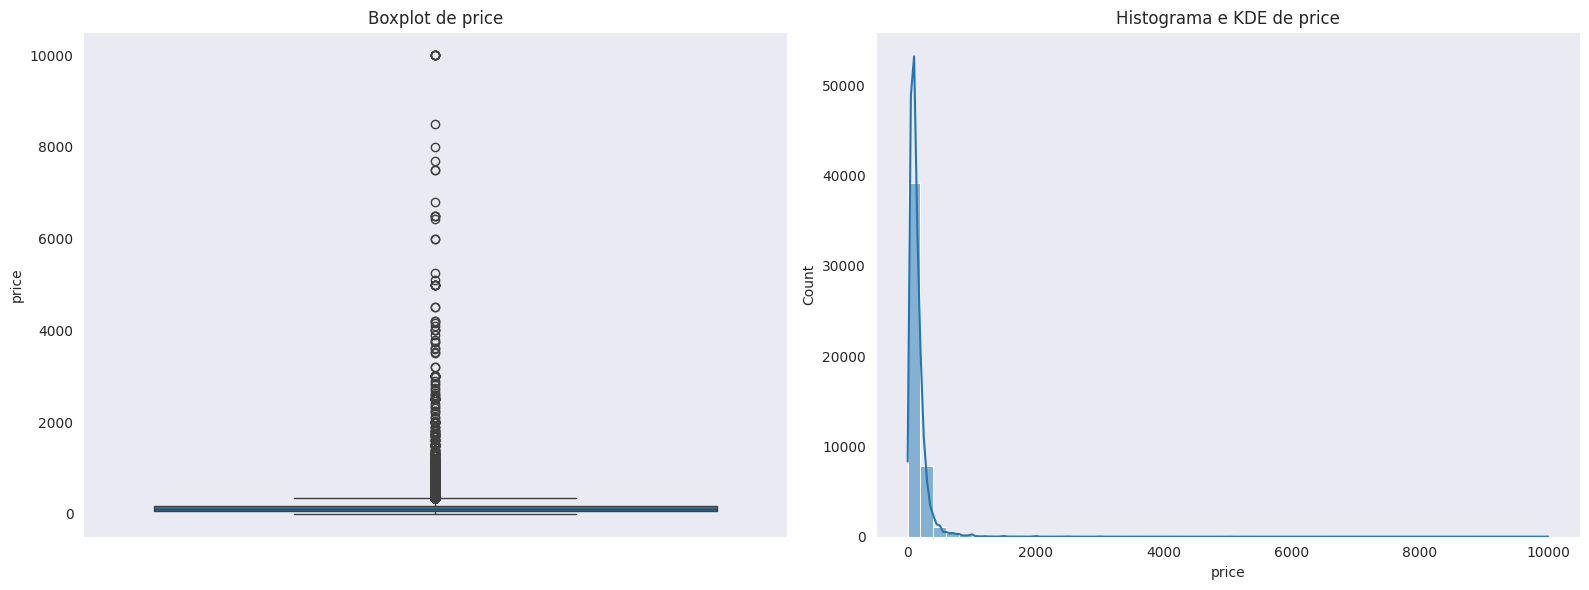

In [14]:
cria_describe_boxplot_hist(dados, "price")

Não só a média como também a mediana está muito abaixo do valor máximo. E comparando a média com a mediana (50%), podemos perceber que a média está sendo esticada pelo possíveis outliers.


Pelo gráfico podemos identificar uma grande quantidade de possíveis outliers com valor até aproximadamente 5000, pela concentração de dados, creio que estes devem ser mantidos. Porém antes de tomar qualquer decisão irei relacionar a quantidade total, com as quantidades acima dos 5000, e com o IQR


Considerando o limite inferior que está em 0, junto o as informações vindas do describe() que possuímos "price" = 0 em alguns valores, vamos contar eles para pensar em futuras estratégias.


In [15]:
dados[dados['price'] > 5000].value_counts().sum()

9

Uma quntidade minuscula se comprado com o volume total dos dados, mas se nao verificado, poderiamso ser enganados pelo o visual do grafico. Para aprofundar, vamos verificar a quantidade de valores acima  do Limite Superior do IQR

In [16]:
q1 = 69
q3 = 175
iqr = q3 - q1
print(f"IQR: {iqr}")
limite_superior = q3 + (1.5 * iqr)
print(f"Limite superior: {limite_superior}")

IQR: 106
Limite superior: 334.0


In [17]:
dados[dados['price'] > limite_superior].value_counts().sum()

1932

Aproximadamente 5% dos valores de Price podem ser considerados outliers, com esta informação o boxplot desta variável deixa de ser assustador. Pela quantidade a provável estratégia será a remoção. Prosseguiremos para analisar a quantidade de price == 0.


In [18]:
dados[dados['price'] == 0].value_counts().sum()

10

Possuimos 10 registros com esse valor, o que comparado com nossa base e insignificante. Logo estes serao removidos apos EDA.

##### 2.1.1.1 Relacionando price com

##### Group Bairro

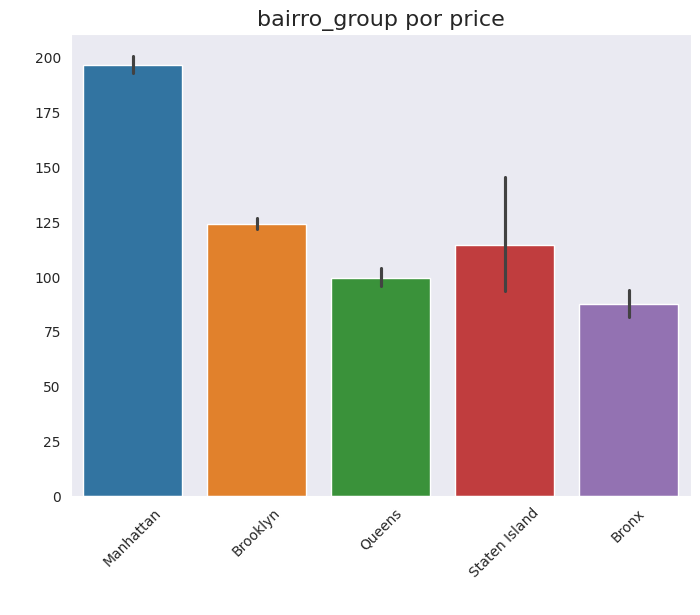

In [19]:
cria_barplot(dados, 'bairro_group', 'price', 'bairro_group')

Manhattan e Brooklyn como esperado tem os locais mais caros, porém Staten Island que normalmente é um região mais afastada e com custo de vida mais baixo, se mantém em 3ro no custo das acomodações temporárias. Talvez pela sua grande qualidade de vida mais calma se comparado às outras regiões.

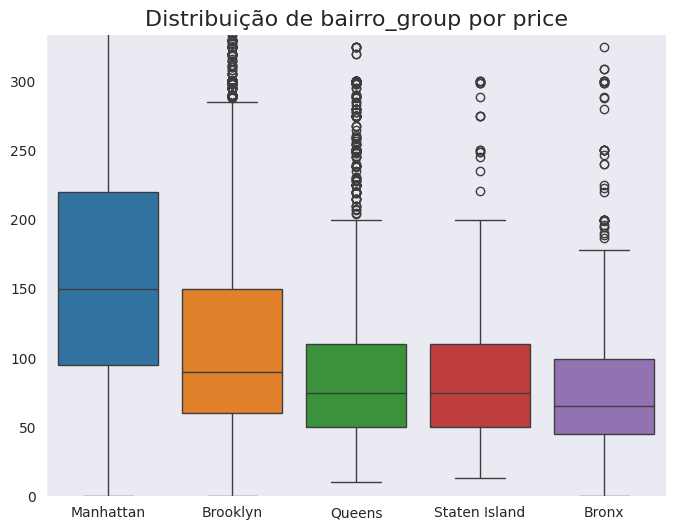

In [20]:
cria_boxplot(dados, 'bairro_group', 'price', 'bairro_group', 334) #Usando o limite superior para vermos o comportamento desta relacao em a interferencia dos outliers

##### Type

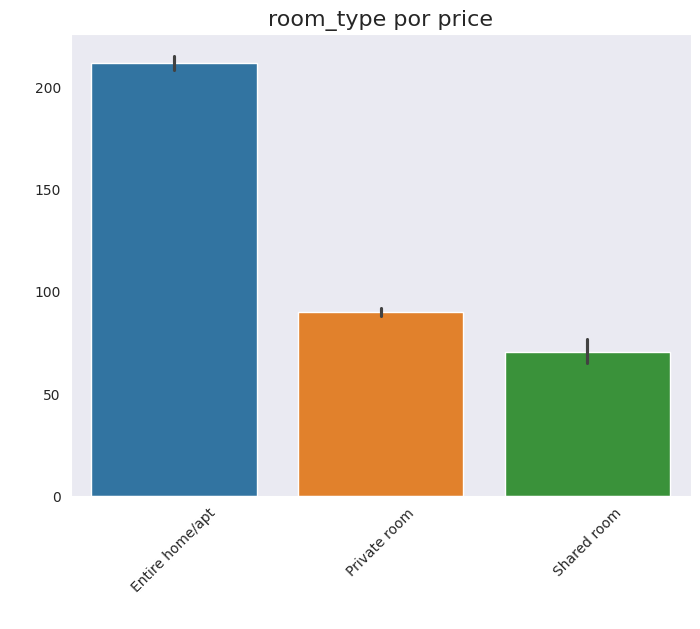

In [21]:
cria_barplot(dados, 'room_type', 'price','room_type')

Como esperado, o custo médio de alugar todo o local é mais alto que os demais. Entretanto, alugar apenas uma sala privada ou uma compartilha se mantém muito próximos, com um leve aumento na sala privada.

##### minimo_noites

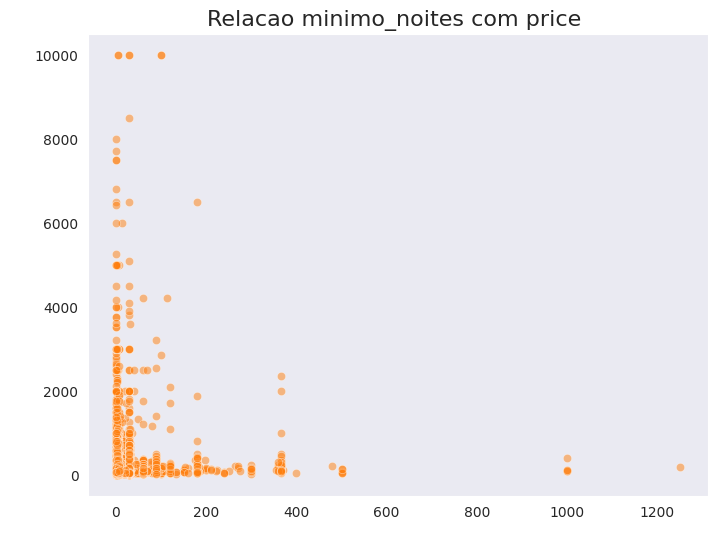

In [22]:
cria_scatterplot(dados, 'minimo_noites', 'price')

Aqui podemos ter um indício da questão 2. Pois, considerando apenas visualmente, parece não haver correlação entre o número de noite X price. Após realizar a EDA voltaremos para estas questões. Outro ponto a ser estudado também é o mínimo de noites impactando diretamente no preço total de um locação, pois uma acomodação com minimo_noites = 5 e preço = 100, na verdade custa 500 e mais 100 a cada noite adicional a partir da 5. Talvez vale criar uma nova variável de preço total mínimo?

##### numero_de_reviews

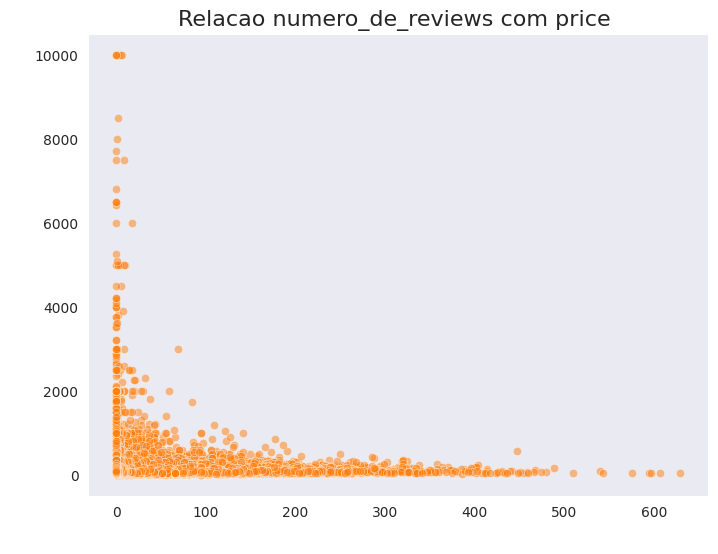

In [23]:
cria_scatterplot(dados, 'numero_de_reviews', 'price')

**ARRUMAR**O número de reviews parece estar bem correlacionado com o preço. Mas não deve indicar uma causalidade, afinal é muito mais provável que tenha muitas avaliações em locais mais baratos que possam ser alugados por uma maior faixa da população. E isto não necessariamente indica que quanto mais reviews uma acomodação tenha, mais barato ela fique. Só que a possibilidade dela ser mais alugada cresce, aumentando também a possibilidade de mais clientes que usaram a acomodação avaliarem ela.

#### 2.1.2 Minimo Noites

count    48894.000000
mean         7.030085
std         20.510741
min          1.000000
25%          1.000000
50%          3.000000
75%          5.000000
max       1250.000000
Name: minimo_noites, dtype: float64


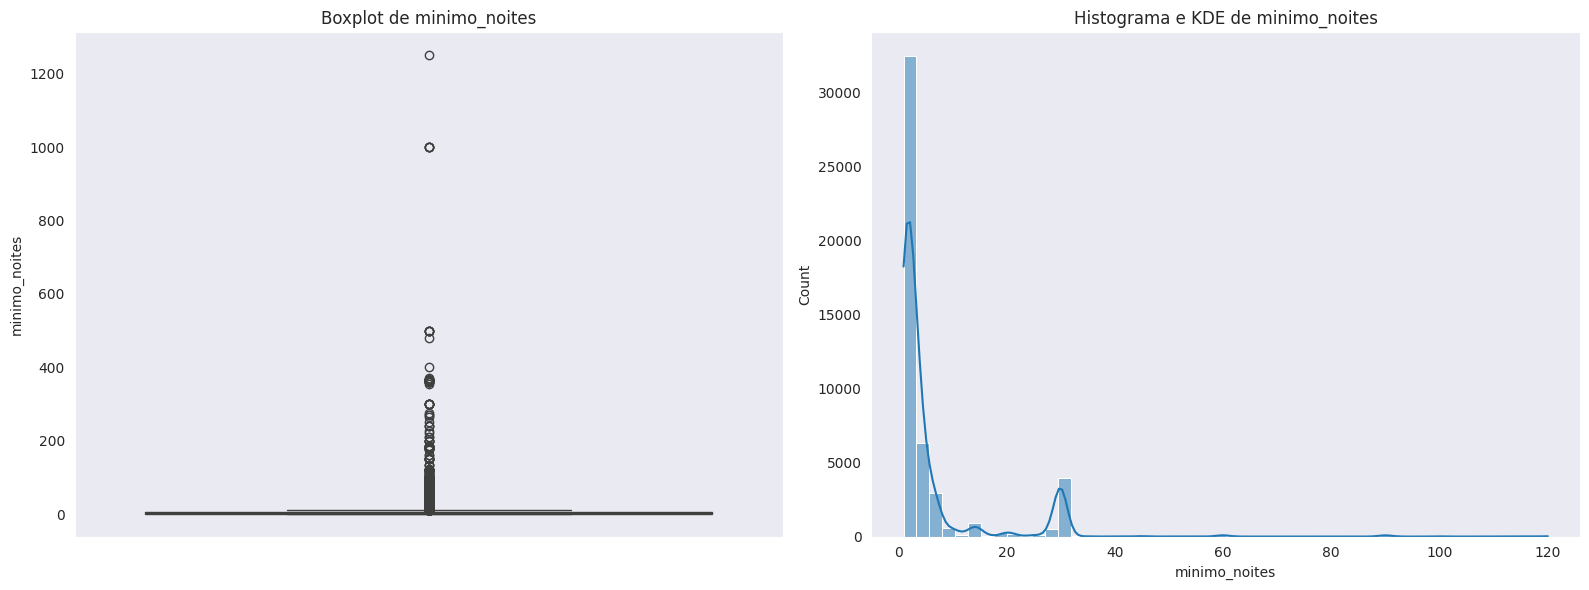

In [24]:
cria_describe_boxplot_hist(dados, 'minimo_noites', filtro="minimo_noites <= 120") #Usando ate 3 meses para melhorar a visualizacao, ja que passando disto sao apenas poucos outliers

Aqui foi usado até um mês de mínimo para entender o padrão da distribuição, poderia ser também 5 dias já que 75% dos valores da variável estão dentro de 5 dias de mínimo. Sobre a distribuição, assimétrica, com mais de um pico e com cauda para a direita. Olhando pelo histograma, podemos  ver que até a faixa de 30 dias/1 mês, indicando que existem, ainda que poucos comparados a minimo_noites = 0, lugares semanais/quinzenais/mensais.

#### 2.1.3 Numero de Reviews

count    48894.000000
mean        23.274758
std         44.550991
min          0.000000
25%          1.000000
50%          5.000000
75%         24.000000
max        629.000000
Name: numero_de_reviews, dtype: float64


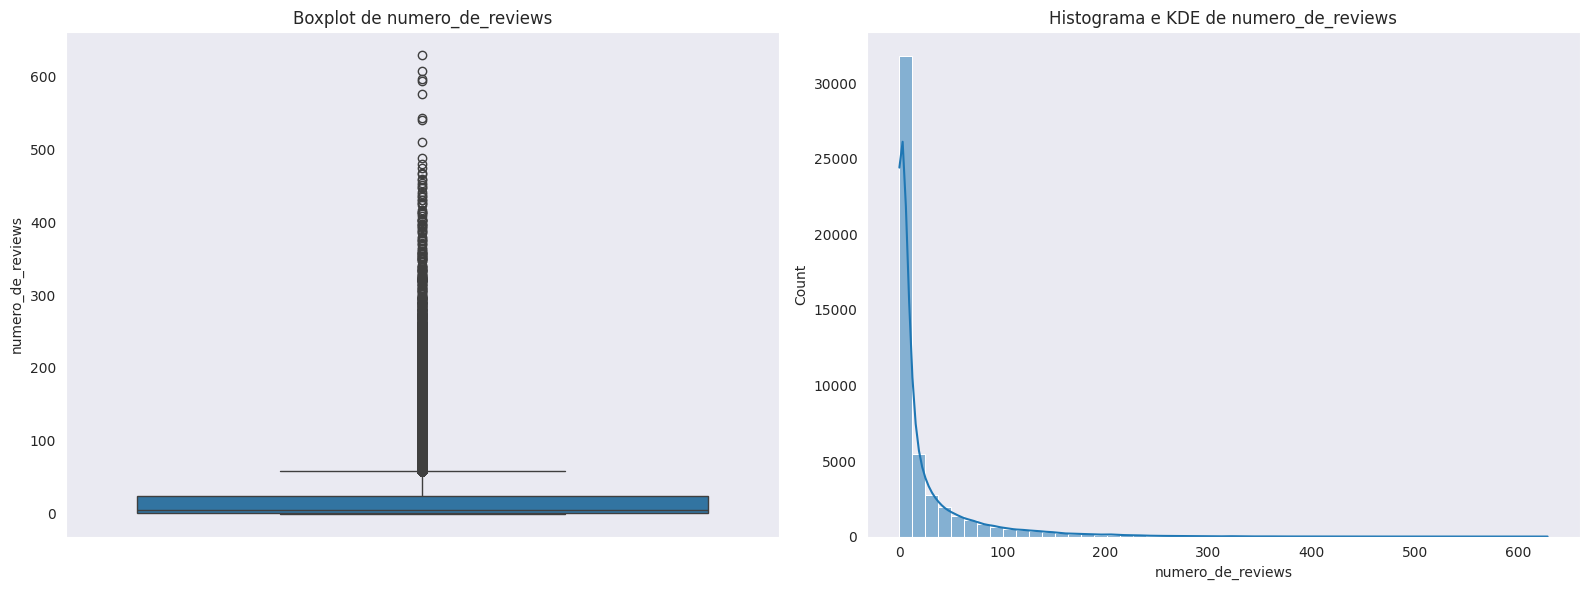

In [25]:
cria_describe_boxplot_hist(dados, 'numero_de_reviews')

Como os demais, uma quantidade absurda de outliers a serem tratados. O comportamento do histograma pode indicar que não existe uma exigência de deixar reviews, pois a grande maioria dos valores se concentra em 0. Ao analisar reviews por mês entraremos mais a fundo nessa questão.

#### 2.1.4 Reviews por Mes

count    38842.000000
mean         1.373251
std          1.680453
min          0.010000
25%          0.190000
50%          0.720000
75%          2.020000
max         58.500000
Name: reviews_por_mes, dtype: float64


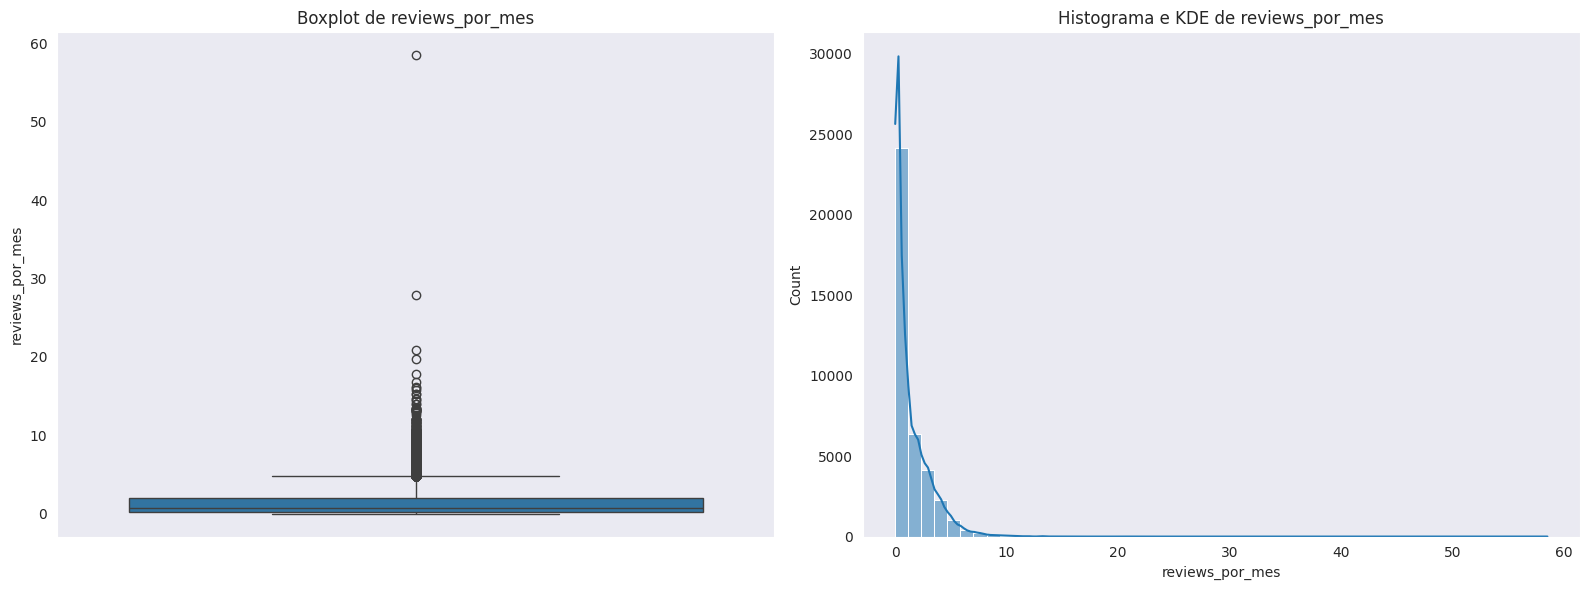

In [26]:
cria_describe_boxplot_hist(dados, 'reviews_por_mes')

Padrao de boxplot das variaveis acima.

m lugar com mais reviews por mês que dias do mês? Só seria possível em caso da locação ficar disponível para alugar por horas. O que sabemos não ser possível, senão em todas, na maioria das plataformas de aluguel temporário.
Ponto interessante de nota, é que o comportamento dos histogramas tanto de numero_de_reviews quanto de reviews_por_mês e extremamente parecido.


Os valores faltantes serão imputados posteriormente. Neste caso iremos optar por preencher os valores nulos com 0, pois é um cenário factível, que acomodacoes não tivesse nenhuma review, principalmente se a plataforma não considerar a review após o uso da locação como algo obrigatório. E não sendo obrigatório, em situações onde a acomodação não seja uma experiência muito boa ou muito ruim, que faça com que queiram avaliar seja positivamente ou negativamente, as pessoas podem simplesmente não avaliar.


Para elucidar minha resposta usarei um comentário retirado do Airbnb:
    * Lembrando que o hóspede não é obrigado a tecer um comentário o que não é muito bom para o anfitrião.
Disponivel em: https://community.withairbnb.com/t5/Ajuda/O-que-acontece-quando-um-hospede-não-faz-a-avaliação/m-p/105906#M3236


#### 2.1.5 Contagem de acomodacoes por host

count    48894.000000
mean         7.144005
std         32.952855
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        327.000000
Name: calculado_host_listings_count, dtype: float64


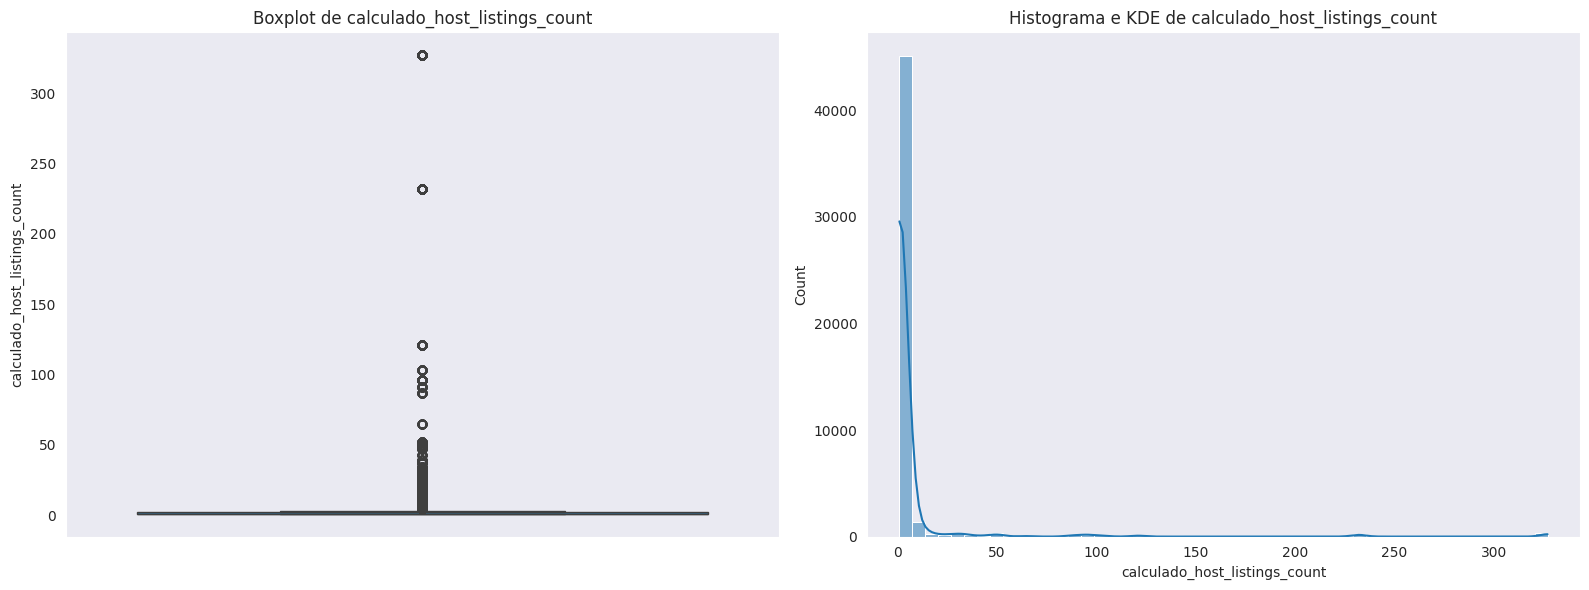

In [27]:
cria_describe_boxplot_hist(dados, 'calculado_host_listings_count')

O mesmo comportamento, com alguns locatários tendo uma quantidade absurda de locações. Até pq o terceiro quartil tem tem como valor 2.

#### 2.1.6 Disponibilidade 365

count    48894.000000
mean       112.776169
std        131.618692
min          0.000000
25%          0.000000
50%         45.000000
75%        227.000000
max        365.000000
Name: disponibilidade_365, dtype: float64


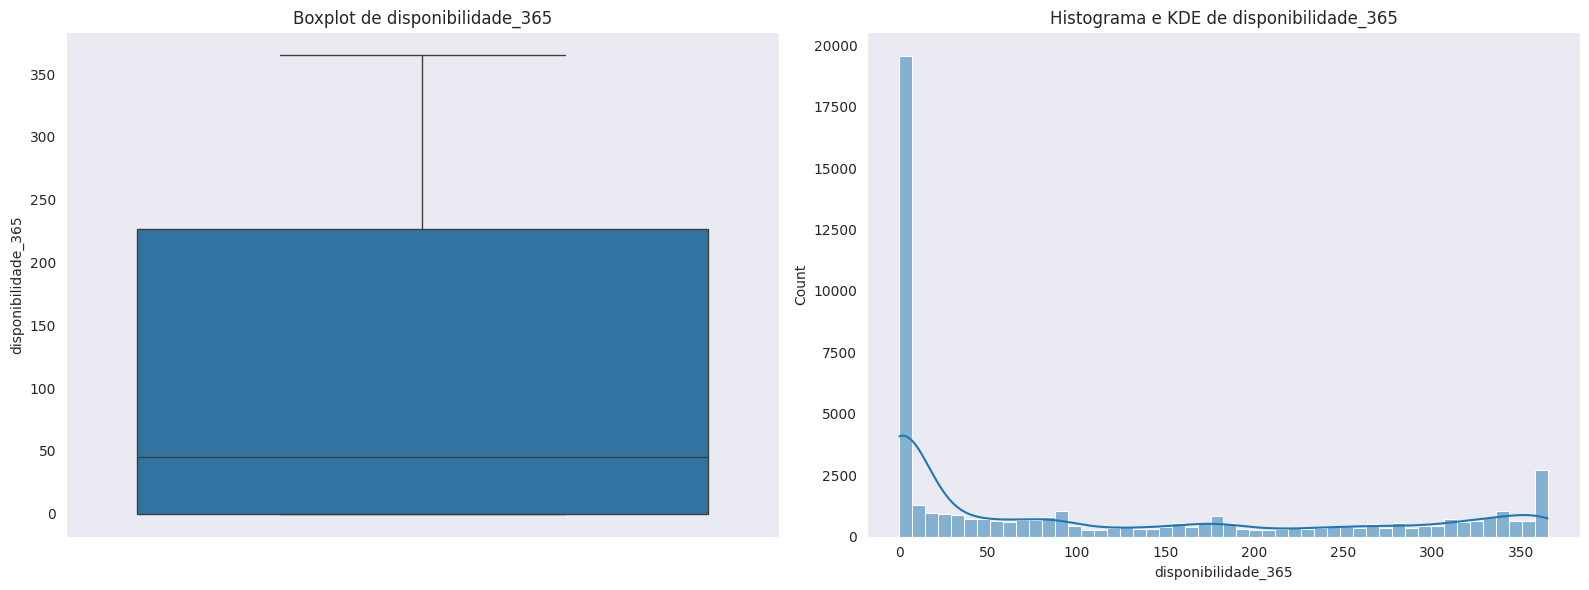

In [28]:
cria_describe_boxplot_hist(dados, 'disponibilidade_365')

Vamos deixar registrado, um boxplot ao menos não teve uma quantidade absurda de outliers!!
Com uma Distribuição claramente assimétrica, com longa cauda a direita.

Nosso primeiro raciocínio sobre a possível exclusão de registros com 0 disponibilidade, acabou de ir água abaixo. Provavelmente foi entendido errado, vamos contar os valores para termos mais certeza numérica.

In [29]:
print(dados['disponibilidade_365'].value_counts().head(20))

disponibilidade_365
0      17533
365     1294
364      491
1        408
89       361
5        340
3        306
179      301
90       290
2        270
6        245
363      239
4        233
8        233
342      230
188      225
7        219
88       200
311      199
341      199
Name: count, dtype: int64


A maior quantidade de disponibilidade é 0, ou seja não tem disponibilidade. Isto significa que já foi locado para todo o ano? Ou está fora de circulação? Apenas com este dataset não terei como responder a esta pergunta. Porém a quantidade é muito grande para excluir, como pensado por primeiro. A não ser que eu  tenha entendido errado, e a disponibilidade significa o quanto ainda tem para ser alugado, porém não creio ser o caso.

#### 2.1.7 Ultima review

Esta também é uma das variáveis com muitos valores nulos, que serão resolvidos posteriormente. Porém terá que ser a primeira variável com uma transformação para poder ser analisada.

In [30]:
df_ultima = dados.copy()
df_ultima['ultima_review'] = pd.to_datetime(df_ultima['ultima_review'])
df_ultima['ultima_review'].describe()

,ultima_review
count,38842
mean,2018-10-04 01:46:50.710055936
min,2011-03-28 00:00:00
25%,2018-07-08 00:00:00
50%,2019-05-19 00:00:00
75%,2019-06-23 00:00:00
max,2019-07-08 00:00:00


<Axes: ylabel='ultima_review'>

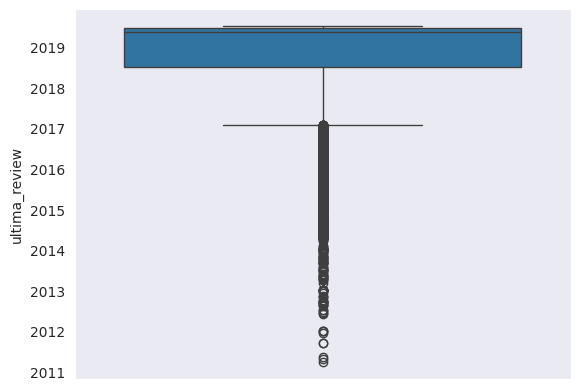

In [31]:
sns.boxplot(df_ultima['ultima_review'])

Com esse boxplot, podemos perceber que a concentração de dados ocorre de 2018 a 2019. Isso pode nos dizer que dos registros que possuem última review são mais recentes. Pensando no futuro desta variável, não vejo utilização dela  no modelo, porém creio ser interessante criar uma nova variável indicando se possui última review recente ou não. Até por que pensando no lado de cliente, uma última review recente nos dá mais certeza de que o local segue nas condições apresentadas. Como modelo de negócio, creio que até 6 meses podem parecer uma review recente, com esta justificativa os dados que tem uma última review em até 6 meses serão considerados recentes e o resto não. Para usar os dados como recente, deixarei definido que o projeto está sendo realizado dia 2019-07-08, dia do último registro disponível.

### 2.2 Variaveis Categoricas

1. host_name
2. bairro_group
3. bairro
4. room_type

#### 2.2.1 host_name

Com esta variavel, a unica analise a fazer agora seria ver quantidade de alocacoes por hosts e se a lista for muito grande, ficar apenas com os 10 primeiro e verificar a media de preco por cada host.

In [32]:
dados['host_name'].value_counts().unique()

array([417, 403, 327, 293, 279, 232, 227, 226, 205, 204, 194, 190, 187,
       182, 160, 157, 154, 151, 146, 143, 142, 140, 139, 135, 134, 131,
       128, 127, 125, 124, 123, 121, 120, 119, 118, 114, 111, 110, 108,
       107, 105, 103, 102, 100,  99,  98,  96,  91,  90,  88,  87,  86,
        84,  83,  82,  81,  80,  79,  78,  77,  76,  75,  74,  72,  71,
        70,  68,  67,  66,  65,  61,  60,  59,  58,  57,  56,  55,  53,
        52,  51,  50,  49,  48,  47,  46,  45,  44,  43,  42,  41,  40,
        39,  38,  37,  36,  35,  34,  33,  32,  31,  30,  29,  28,  27,
        26,  25,  24,  23,  22,  21,  20,  19,  18,  17,  16,  15,  14,
        13,  12,  11,  10,   9,   8,   7,   6,   5,   4,   3,   2,   1])

Comforme o esperado, tem-se muitos locatarios diferentes. Analisaremos os 10 primeiros.

In [33]:
dados['host_name'].value_counts().head(10)

,count
host_name,
Michael,417
David,403
Sonder (NYC),327
John,293
Alex,279
Blueground,232
Sarah,227
Daniel,226
Jessica,205


Porém podemos notar que que estes possuem uma grande quantidade, talvez esta isso implique algo em 'price', poderia transformar os dados usando alguém Encoder para calcular a correlação com a variável algo. Após as visualizações dos host, voltaremos a este ponto.

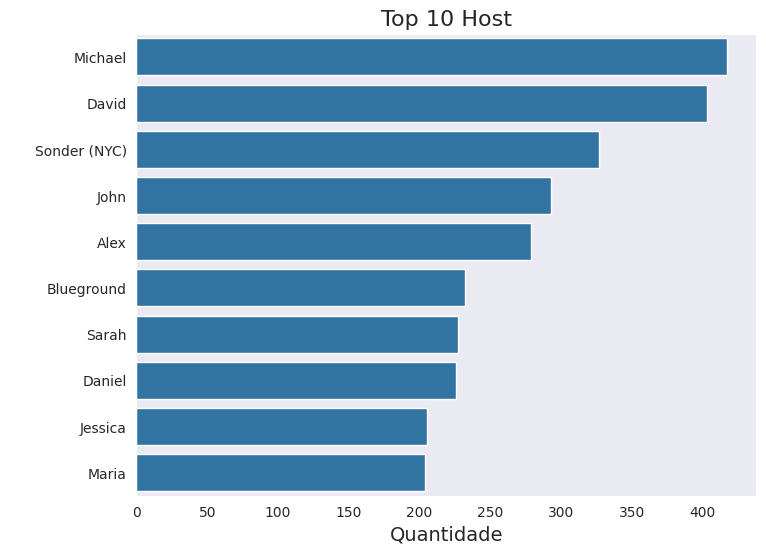

In [34]:
top_10_host = dados['host_name'].value_counts().head(10).sort_values(ascending=False)
cria_barh(top_10_host, 'Top 10 Host')

Qual porcentagem do mercados estes 10 possuem? E Sao eles que possuem os maiores lucros brutos?

In [35]:
# Porcentagem de alocações
hosts_com_mais_alocacoes = dados['host_name'].value_counts().head(10)
hosts_com_mais_alocacoes_pct = (hosts_com_mais_alocacoes / dados.shape[0]) * 100
print(hosts_com_mais_alocacoes_pct)

host_name
Michael         0.852865
David           0.824232
Sonder (NYC)    0.668794
John            0.599256
Alex            0.570622
Blueground      0.474496
Sarah           0.464270
Daniel          0.462224
Jessica         0.419274
Maria           0.417229
Name: count, dtype: float64


Por um momento achei que veríamos grandes valores, por esse momento deve ter esquecido que possuímos quase 50k de registros e estamos falando de NYC. Fui amado e não negarei.


E para comparação, iremos explorar os 10 host que possuem maior lucro, se somando apenas o preço de cada locação, afim de saber se os host com maior quantidade também são os que mais lucram.


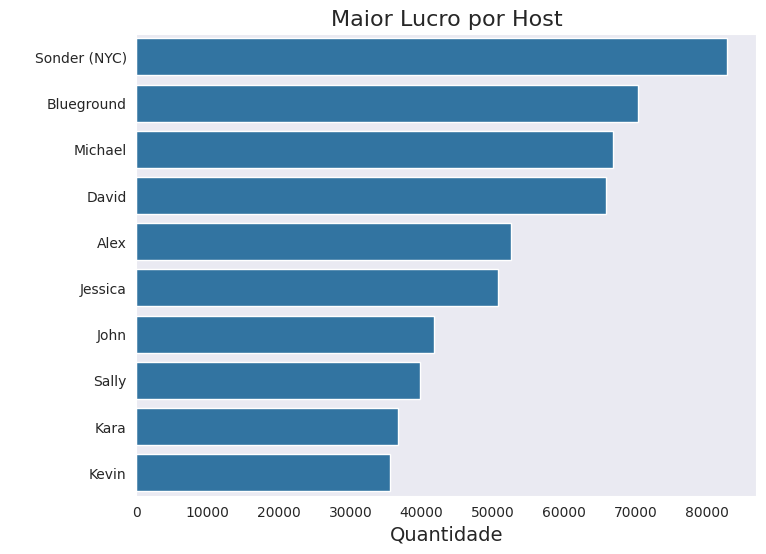

In [36]:
top_10_host_lucro = dados.groupby('host_name')['price'].sum().sort_values(ascending=False).head(10)
cria_barh(top_10_host_lucro, 'Maior Lucro por Host')

Michael e David que possuem aproximadamente 0.85 do mercado de locacoes temporarias, configuram apenas o 3 e 4 posto de maior lucro. Ficando atras de Sonder e Blueground este que possui, quase que metade da quantidade de locacoes de Michael e David tem um lucro de 10000 a mais.

In [37]:
encoder = LabelEncoder()
dados_host_copy = dados.copy()
dados_host_copy['host_name_codificado'] = encoder.fit_transform(dados_host_copy['host_name'])
correlation = dados_host_copy['host_name_codificado'].corr(dados_host_copy['price'])

correlation

0.0012976035819978746

Retornamos ao ponto da correlação de host X price, para notarmos que não existe simplesmente uma correlação entre estas variáveis. Afinal 0.001 poderia ser arredondado para 0.


#### 2.2.2 bairro_group

In [38]:
dados['bairro_group'].value_counts()

,count
bairro_group,
Manhattan,21661
Brooklyn,20103
Queens,5666
Bronx,1091
Staten Island,373


Aqui temos mais um ponto que corrobora com a questão 2, Staten Island possuem a menor quantidade de listagem e o 3 maior preço médio como visto no gráfico em comparação com price.

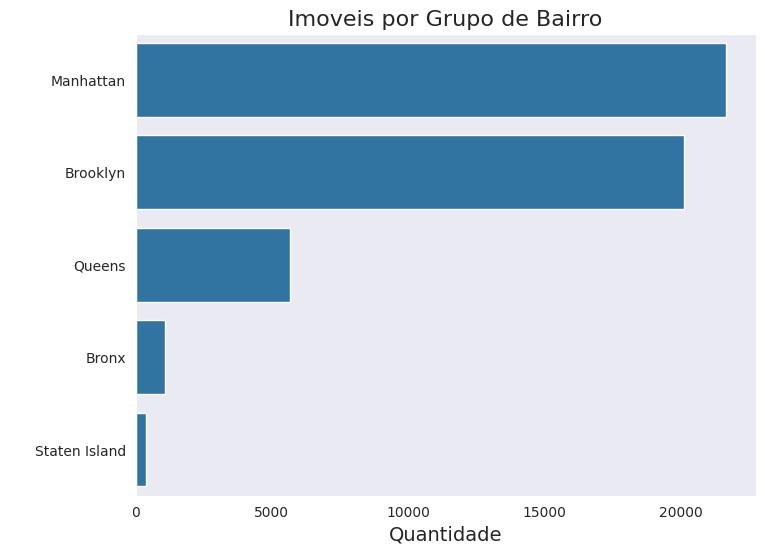

In [39]:
distribuicao_bairro_group = dados['bairro_group'].value_counts(ascending=False)
cria_barh(distribuicao_bairro_group, 'Imoveis por Grupo de Bairro')

A quantidade de imoveis por bairro_group se assemelha as reviews?

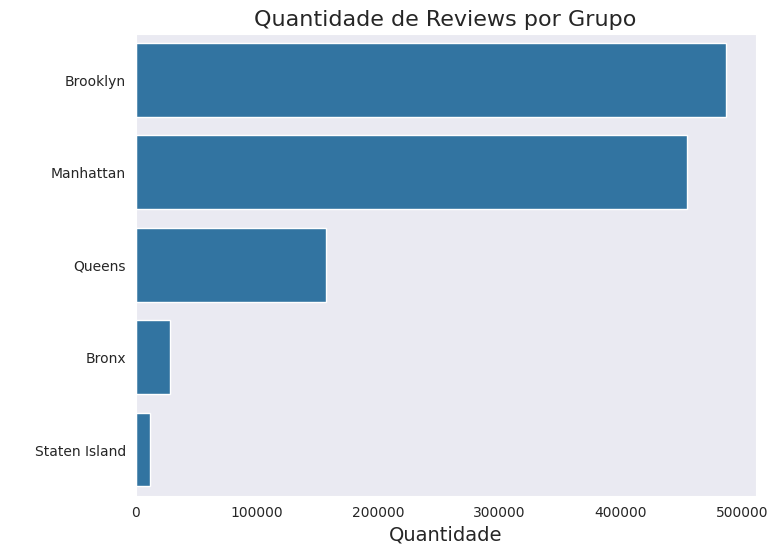

In [40]:
reviews_bairro_group = dados.groupby('bairro_group')['numero_de_reviews'].sum().sort_values(ascending=False).head(10)
cria_barh(reviews_bairro_group, 'Quantidade de Reviews por Grupo')

A única diferença entre a quantidade de alocações por grupo de bairro para reviews por grupo de bairro, está na ordem dos dois primeiros, enquanto Manhattan tem mais locações disponíveis, o Brooklyn possui mais reviews em suas locações. A disponibilidade também segue este comportamento?

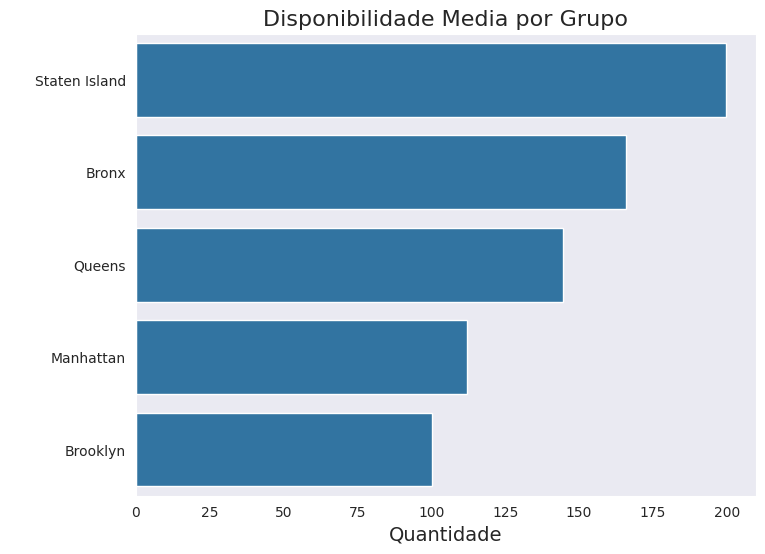

In [41]:
disponibilidade_media = dados.groupby('bairro_group')['disponibilidade_365'].mean().sort_values(ascending=False)
cria_barh(disponibilidade_media, 'Disponibilidade Media por Grupo')

Aqui temos outro ponto interessante para a questão que deve ser respondida, pois com uma grande disponibilidade média em Staten Island, significa concorrência por mais tempo. Porém este valor não deve afetar tanto pois é uma diferença pequena se comparado com a diferença de quantidade de locações disponíveis entre Staten Island e as com maior quantidade.

#### Bairro

Os bairros isolados têm comportamento semelhante aos grandes grupos? Para isso iremos analisar os preços médios por bairros e grupos de bairro. Considerando que são muitos bairros, usaremos 5 bairros de cada grupo de bairro com os maiores preços médios.


In [42]:
preco_medio_por_bairro_grupo = dados.groupby(['bairro_group', 'bairro'])['price'].mean().reset_index()
preco_medio_por_bairro_grupo = preco_medio_por_bairro_grupo.sort_values(['bairro_group', 'price'], ascending=[True, False])

top_5_bairros_por_grupo = preco_medio_por_bairro_grupo.groupby('bairro_group').head(5)
top_5_bairros_por_grupo = top_5_bairros_por_grupo.sort_values('price', ascending=False)

top_5_bairros_por_grupo

,bairro_group,bairro,price
188,Staten Island,Fort Wadsworth,800.000000
220,Staten Island,Woodrow,700.000000
121,Manhattan,Tribeca,490.638418
88,Brooklyn,Sea Gate,487.857143
34,Bronx,Riverdale,442.090909
204,Staten Island,Prince's Bay,409.500000
95,Manhattan,Battery Park City,367.557143
102,Manhattan,Flatiron District,341.925000
205,Staten Island,Randall Manor,336.000000
115,Manhattan,NoHo,295.717949


Ponto importante a notar, Staten Island, entre os 10 bairros mais caros, possui 4 posições. Talvez seja um bom lugar para investir. Voltaremos mais tarde a este ponto.

#### Room Type

In [43]:
dados['room_type'].value_counts()

,count
room_type,
Entire home/apt,25409
Private room,22325
Shared room,1160


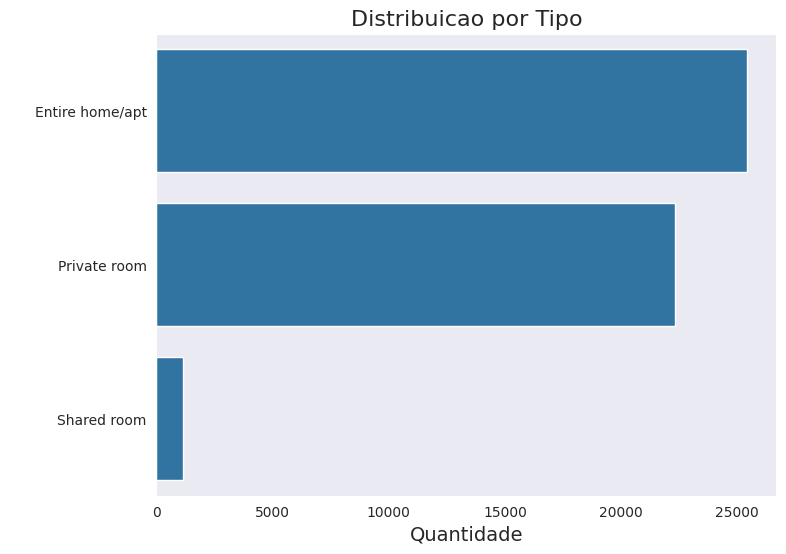

In [44]:
distribuicao_room_type = dados['room_type'].value_counts(ascending=False)
cria_barh(distribuicao_room_type, 'Distribuicao por Tipo')

Podemos ver claramente a predominância de Private/Entire, indicando que as pessoas que alugam acomodações preferem a privacidade, seja de uma casa toda ou quarto todo, mesmo tendo uma boa diferença de preço médio, como visto acima. Onde Private room tem média parecida com Shared Room e estes ficam com preço bem mais abaixo que uma Entire Home/Apt.

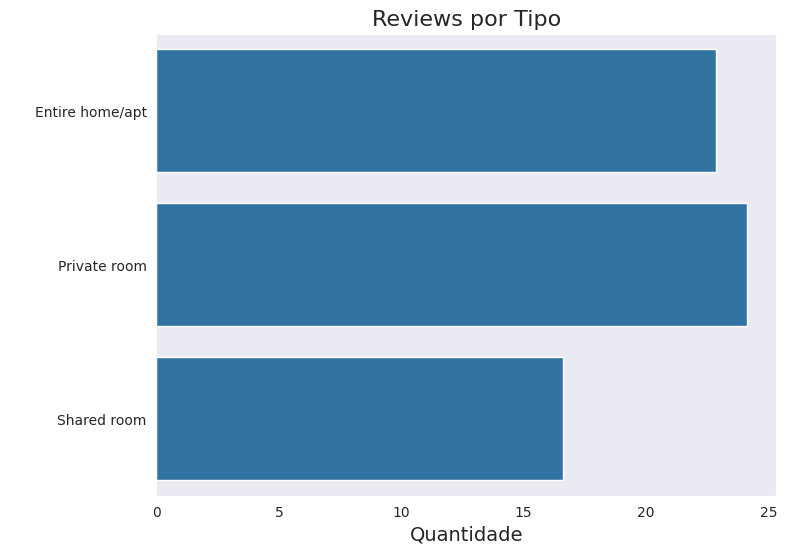

In [45]:
reviews_room_type = dados.groupby('room_type')['numero_de_reviews'].mean()
cria_barh(reviews_room_type, 'Reviews por Tipo')

Aqui podemos notar que Shared Room tem uma maior quantidade de Reviews relativa, pois fica apenas um pouco atrás dos dois outros tipos, mesmo tendo uma quantidade significativamente menor de registros.

Já comparamos a quantidade de acomodações por grupo e por tipo, vamos juntar os dois e comparar por tipo e grupo juntos, para ver se os comportamentos estão perdidos como um todo.

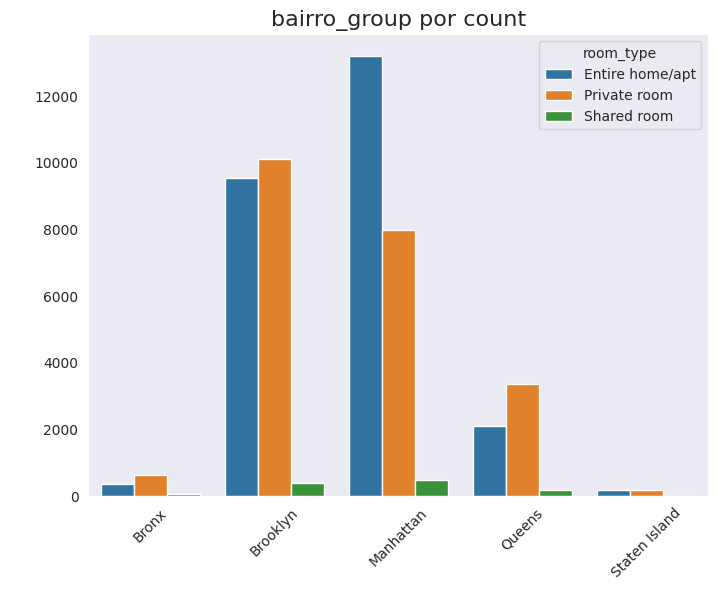

In [46]:
dados_agrupados = dados.groupby(['bairro_group', 'room_type']).size().reset_index(name='count')
cria_barplot(dados_agrupados, 'bairro_group', 'count', 'room_type') # devido a maneira que a funcao foi feita, o titulo ficou um pouco zoado.

Importante notar que os usuários que param em acomodações compartilhadas tendem muito mais a deixar um review, pois a disparidade de quantidade não tem nada a ver com o comportamento dos reviews deixados nos grupos.


### Localizacao

Vamos analisar em relação a:


* Disponibilidade
* Grupo de bairro
* Tipo de acomodação


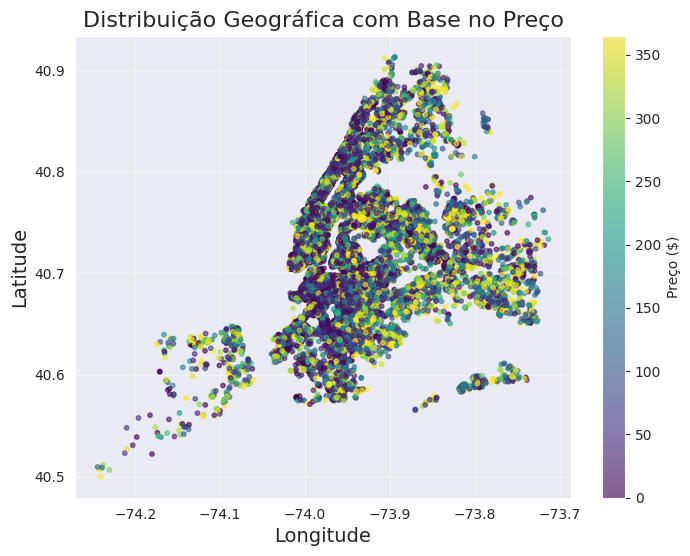

In [47]:
plt.figure(figsize=(8, 6))
plt.scatter(dados['longitude'], dados['latitude'], c=dados['disponibilidade_365'], cmap='viridis', alpha=0.6, s=10)
plt.colorbar(label='Preço ($)', orientation='vertical')
plt.title('Distribuição Geográfica com Base no Preço', fontsize=16)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.grid(True, alpha=0.5)
plt.show()

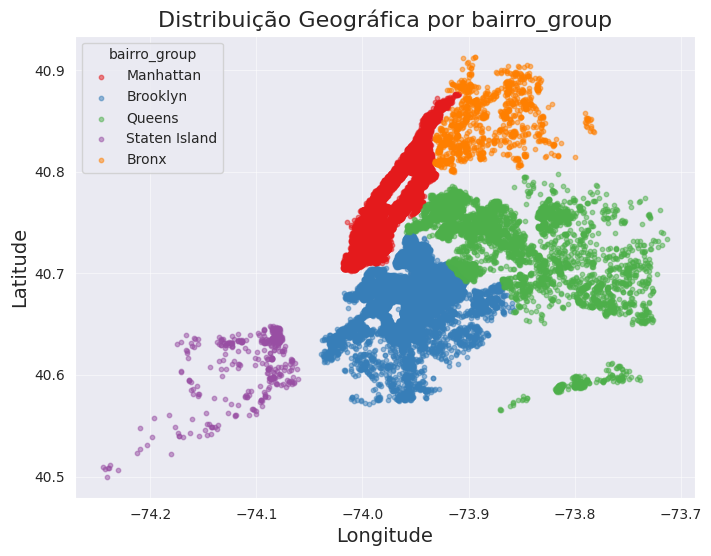

In [48]:
cria_dist_geo(dados, 'bairro_group')

Pela distribuicao e densidade Manhattan, Brooklyn e Queens ja parecem bastante saturada, com pontos por toda a regiao, tanto nas bordas quanto no centro.

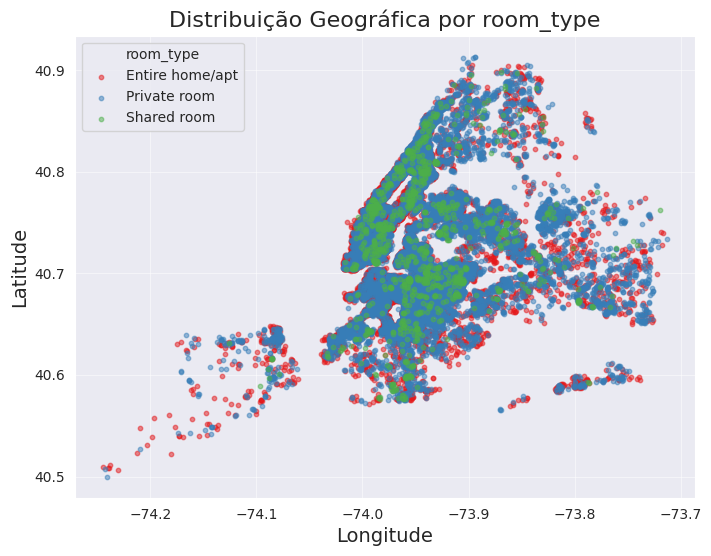

In [49]:
cria_dist_geo(dados, 'room_type')

Com esta distribuição podemos perceber que "Shared room" possui grande foco em Manhattan e Brooklyn e alguns pingados no Queens. Com Bronx e Staten Island com pouquíssima quantidade de quartos compartilhados, principalmente Staten Island. O que deve pode ser explicado tanto pela maior urbanização nessas áreas, como maior agitações nestes, principalmente, dois centros.

## Questoes a serem respondidas:

1. Supondo que uma pessoa esteja pensando em investir em um apartamento para alugar na plataforma, onde seria mais indicada a compra?
2. O número mínimo de noites e a disponibilidade ao longo do ano interferem no preço?
3. Existe algum padrão no texto do nome do local para lugares de mais alto valor?


### 1.

Para investimento em um apratamento para alugar, com base nos dados, seria mais indicado em **Staten Island**. Pois possui o terceiro maior preco medio das acomodacoes, tambem conta com uma qauntidade de acomodacoes regsitradas muito menor que Manhttan e Brooklyn, ou seja teremos menos concorrentes. Porem como ponto negativo, os concorrentyes ja intaladas tem uma grande disponibilidade de dias para serem alugados.

### 2.

In [50]:
dados[['minimo_noites','disponibilidade_365', 'price']].corr()

,minimo_noites,disponibilidade_365,price
minimo_noites,1.000000,0.144320,0.042799
disponibilidade_365,0.144320,1.000000,0.081833
price,0.042799,0.081833,1.000000


As duas variaveis nao impactuam no preco, ja que possuem uma correlacao abaixo de 0.1.

### 3.

In [51]:
# Definir o limite do quantil 90 para considerar locais de alto valor
limite_valor_alto = dados['price'].quantile(0.90)

# Filtrar os locais que têm um valor acima do quantil 90
locais_alto_valor = dados[dados['price'] >= limite_valor_alto]

# Contar a frequência de cada nome de local
frequencia_nomes_completos = locais_alto_valor['nome'].value_counts()

# Exibir os nomes completos dos locais e a quantidade de vezes que aparecem
print("Nomes completos dos locais mais frequentes:")
print(frequencia_nomes_completos.head(10))

Nomes completos dos locais mais frequentes:
nome
Are You Ready for Central Park State of Mind?                           4
Sonder | The Biltmore | Spacious 1BR + Kitchen                          3
Sixth Ave Chelsea, 1bd Serviced Apartment                               3
West Village Apartment                                                  3
New york Multi-unit building                                            3
Studio Penthouse                                                        3
Tribeca Loft                                                            2
Lower East Side Luxury                                                  2
Rooftop Oasis in Brooklyn for Shoots & Gigs                             2
*NO GUEST SERVICE FEE* Luxury Midtown One Bedroom Suite with Kitchen    2
Name: count, dtype: int64


OS apartamento de mais alto valor, sao provavelmente, com vista para o Central Park.

## 2. Pre-Processamento

Aqui utilizaremos uma funcao para transformar, limpar, e criar as variavies necessarias para o treinamento.


In [52]:
dados.head(1) #Para ver a estrutura

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355


Vamos criar um boxplot das variaveis numericas brutas antyes do processamento, e apos os recriamos para comparar as estruturas.

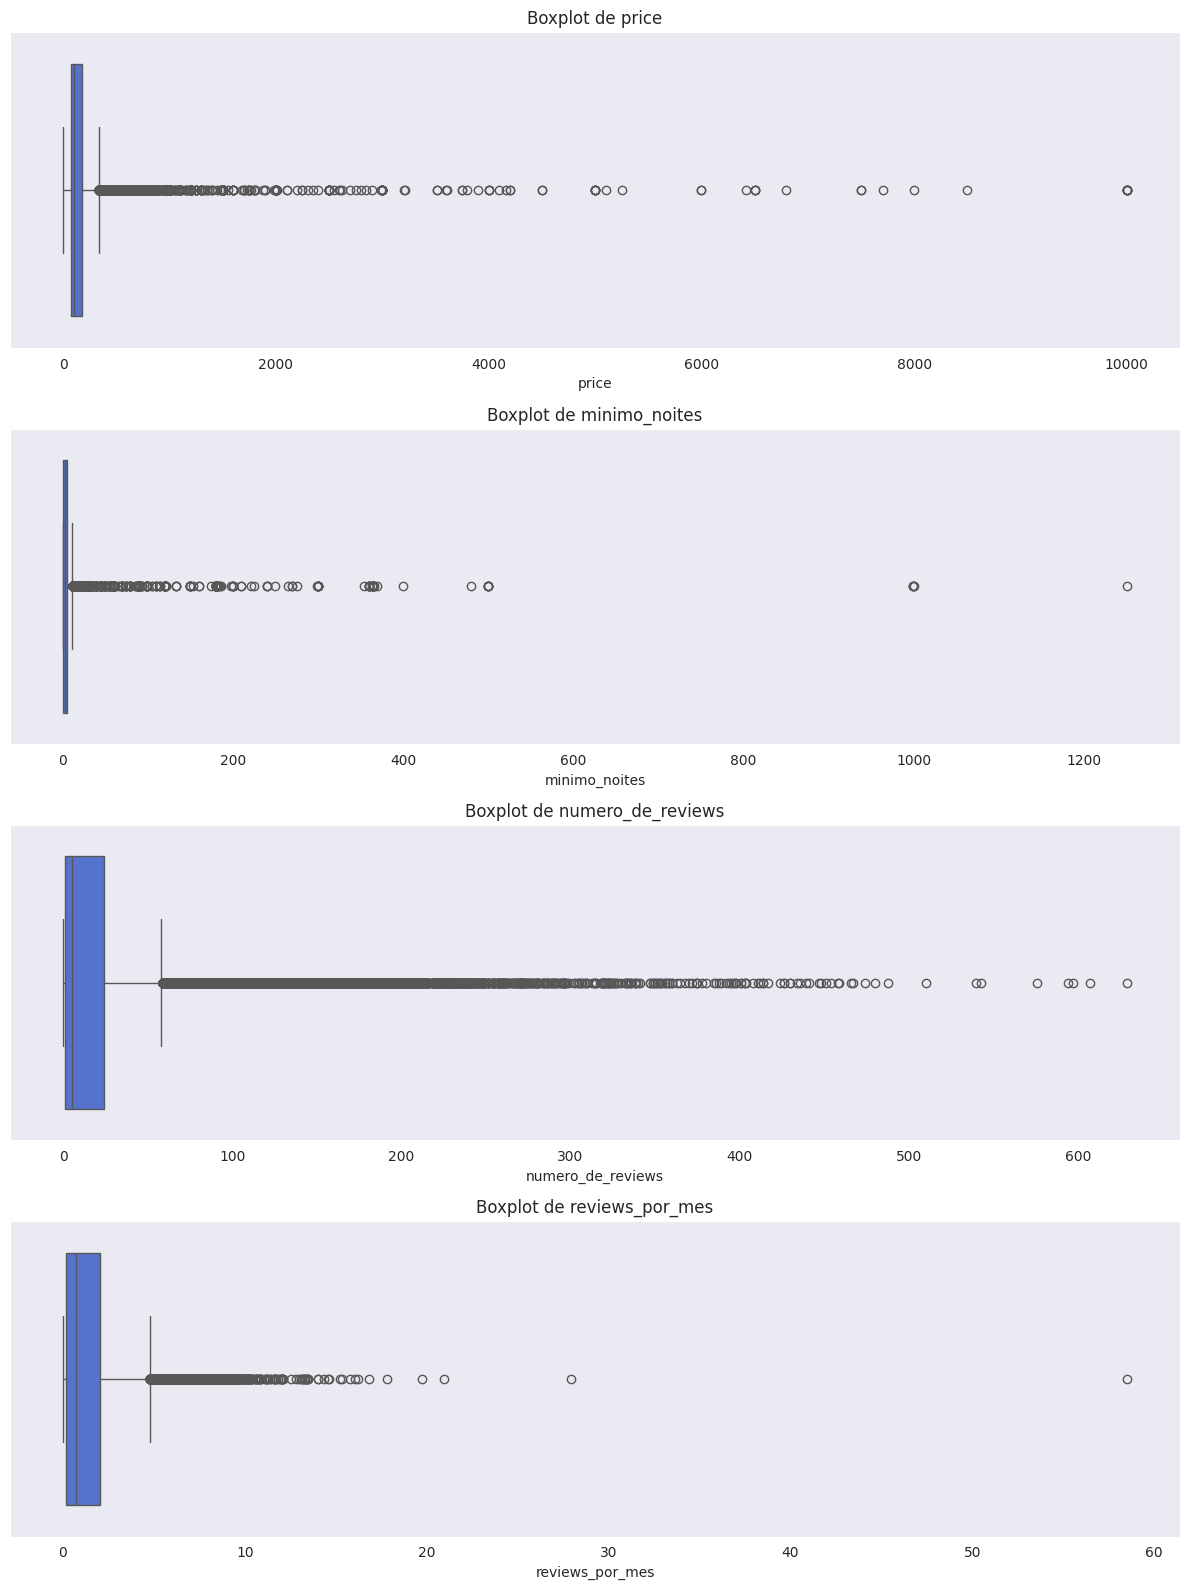

In [53]:
numericas = ['price', 'minimo_noites', 'numero_de_reviews', 'reviews_por_mes']
plot_boxplots(dados, numericas)

In [54]:
def organiza_treino(dados: pd.DataFrame):

  nao_usadas = ['id', 'nome', 'host_id', 'host_name', 'calculado_host_listings_count']
  numericas = ['price', 'minimo_noites', 'numero_de_reviews', 'reviews_por_mes']
  dados_usaveis = dados.drop(columns=nao_usadas)
  dados_usaveis = dados_usaveis[dados_usaveis['price'] != 0]

  ultimo_dia = pd.to_datetime('2019-07-08') #Considerado o ultimo dia disponivel nos dados.
  dados_usaveis['ultima_review'] = pd.to_datetime(dados_usaveis['ultima_review'])
  dados_usaveis['review_recente'] = (dados_usaveis['ultima_review'] >= ultimo_dia - pd.DateOffset(months=6)).astype(int)
  dados_usaveis = dados_usaveis.drop(columns='ultima_review')

  dados_usaveis['reviews_por_mes'] = dados_usaveis['reviews_por_mes'].fillna(0)

  dados_usaveis = pd.get_dummies( dados_usaveis, columns=['bairro_group', ], prefix='bairro_group', drop_first=False)
  dados_usaveis = pd.get_dummies(dados_usaveis, columns=['room_type'], prefix='room', drop_first=False)

  bairro_freq = dados_usaveis['bairro'].value_counts(normalize=True)  # Frequência relativa
  dados_usaveis['bairro_encoded'] = dados_usaveis['bairro'].map(bairro_freq)
  dados_usaveis = dados_usaveis.drop(columns=['bairro'])


  for coluna in numericas:
      Q1 = dados_usaveis[coluna].quantile(0.25)  # (25%)
      Q3 = dados_usaveis[coluna].quantile(0.75)  # (75%)
      IQR = Q3 - Q1  # Intervalo interquartil
      lim_inf = Q1 - 1.5 * IQR  # LQue provavelmnete nao usaremos
      lim_sup = Q3 + 1.5 * IQR

      dados_usaveis = dados_usaveis[(dados_usaveis[coluna] >= lim_inf) & (dados_usaveis[coluna] <= lim_sup)]

  return dados_usaveis

In [55]:
df_treino = organiza_treino(dados)

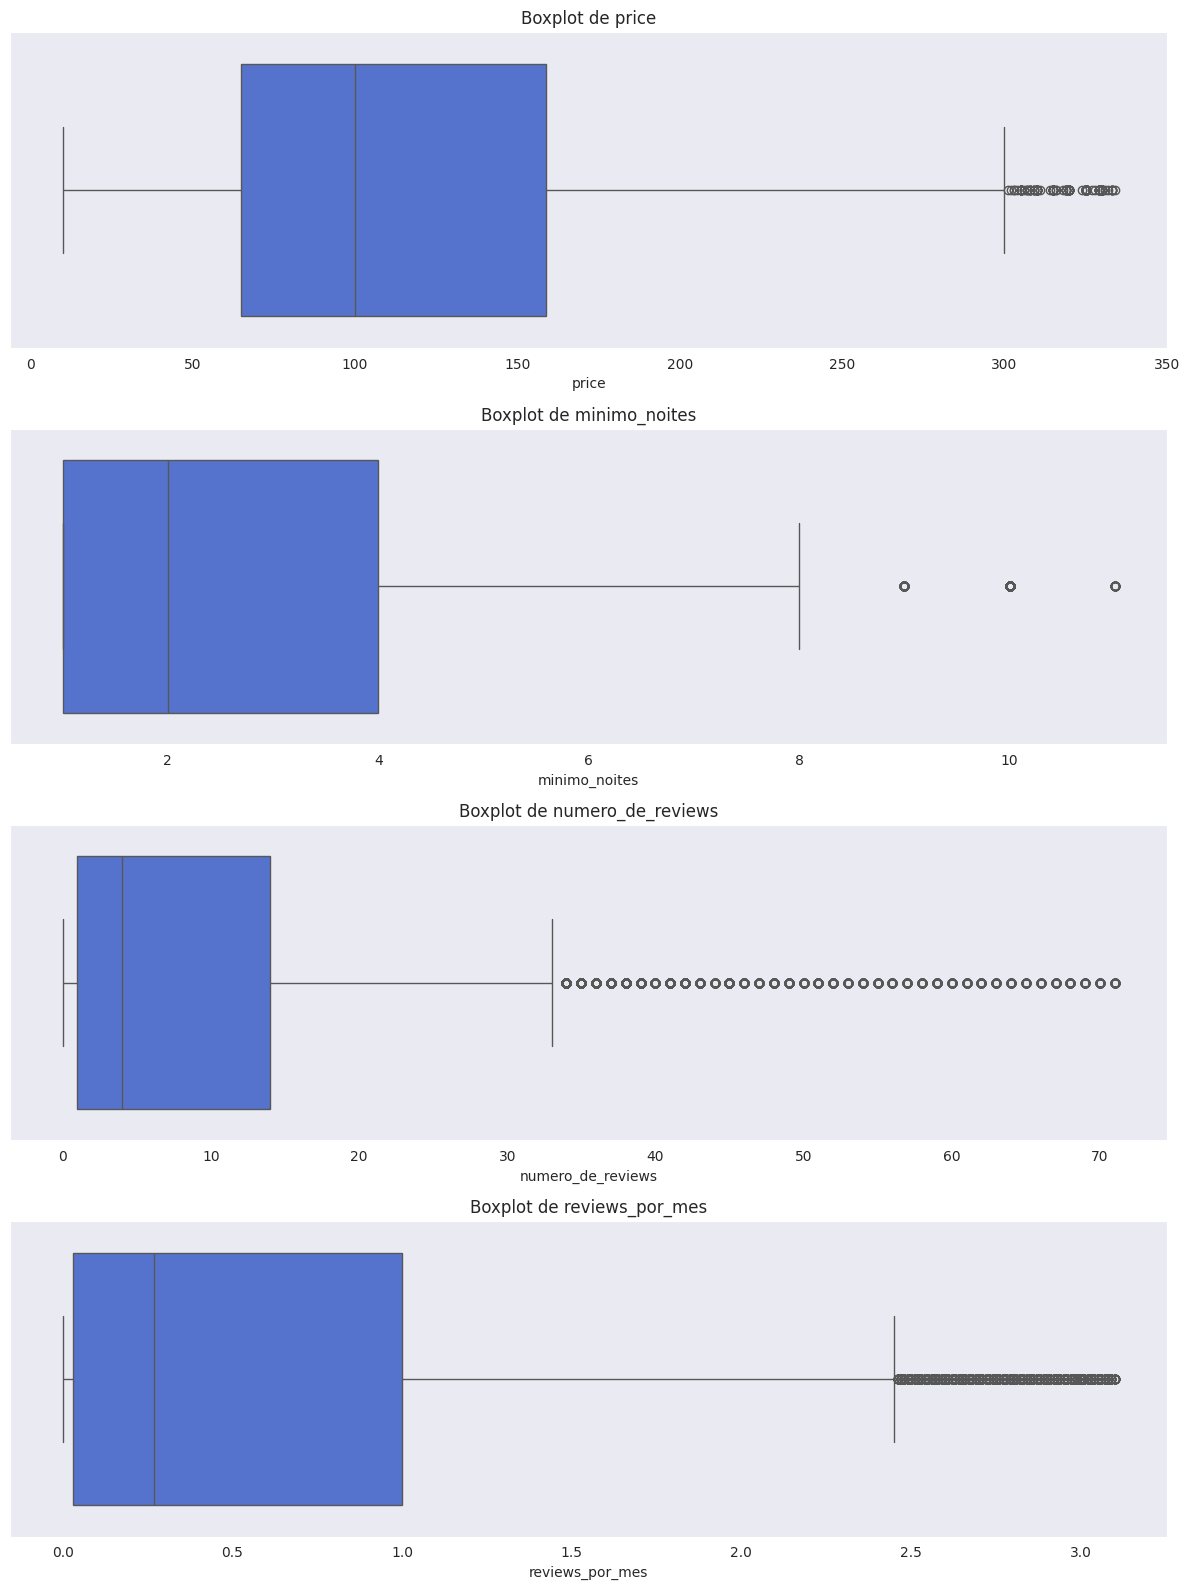

In [56]:
numericas = ['price', 'minimo_noites', 'numero_de_reviews', 'reviews_por_mes']
plot_boxplots(df_treino, numericas)

In [57]:
df_treino.columns

Index(['latitude', 'longitude', 'price', 'minimo_noites', 'numero_de_reviews',
       'reviews_por_mes', 'disponibilidade_365', 'review_recente',
       'bairro_group_Bronx', 'bairro_group_Brooklyn', 'bairro_group_Manhattan',
       'bairro_group_Queens', 'bairro_group_Staten Island',
       'room_Entire home/apt', 'room_Private room', 'room_Shared room',
       'bairro_encoded'],
      dtype='object')

## 3. Modelagem

Neste primeiro momento realizamos duas divisões de train test split,uma para diminuir os dados, e desta divisão pegamos um subset para que os experimentos ao rodar múltiplos modelos e procurar seus melhores parâmetros não demore mais que o necessário. Para isso usaremos 20% dos dados.

In [58]:
X_sub, _, y_sub, _ = train_test_split(
    df_treino.drop(columns='price'),
    df_treino['price'],
    test_size = 0.8,
    random_state=42
)

X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(
    X_sub,
    y_sub,
    test_size = 0.2,
    random_state=42
)

In [59]:
X_train_small.columns #COnferindo a consistencia

Index(['latitude', 'longitude', 'minimo_noites', 'numero_de_reviews',
       'reviews_por_mes', 'disponibilidade_365', 'review_recente',
       'bairro_group_Bronx', 'bairro_group_Brooklyn', 'bairro_group_Manhattan',
       'bairro_group_Queens', 'bairro_group_Staten Island',
       'room_Entire home/apt', 'room_Private room', 'room_Shared room',
       'bairro_encoded'],
      dtype='object')

### 3.1 Modelo Base

Comomodelo base usaremos uma simples regressao linear.

In [60]:
modelo_base = LinearRegression()
modelo_base.fit(X_train_small,  y_train_small)


y_pred = modelo_base.predict(X_test_small)


mae = mean_absolute_error(y_test_small, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_small, y_pred))
r2 = r2_score(y_test_small, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

MAE: 36.16
RMSE: 47.97
R²: 0.4912


Como ponto de partida temos que ganhar este modelo de regressão linear. Vamos então rodar um experimento usando modelos diferentes, para escolher os mais aptos para a seguinte etapa. A qual será a escolha de hiperparâmetros usando GridSearchCV nos modelos escolhidos.

In [61]:
def rodar_experimentos(X_train_small, X_test_small, y_train_small, y_test_small):

    modelos = {
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Decision Tree': DecisionTreeRegressor(random_state=42),
        'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
        'Lasso': Lasso(alpha=0.1),
        'Ridge': Ridge(alpha=1.0)
    }

    resultados = {}

    for nome, modelo in modelos.items():

        modelo.fit(X_train_small, y_train_small)

        y_pred = modelo.predict(X_test_small)

        mae = mean_absolute_error(y_test_small, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test_small, y_pred))
        r2 = r2_score(y_test_small, y_pred)


        resultados[nome] = {
            'MAE': mae,
            'RMSE': rmse,
            'R²': r2
        }

    for nome, metrica in resultados.items():
        print(f"{nome}:")
        print(f"  MAE: {metrica['MAE']:.2f}")
        print(f"  RMSE: {metrica['RMSE']:.2f}")
        print(f"  R²: {metrica['R²']:.4f}")
        print("-____________________-")

rodar_experimentos(X_train_small, X_test_small, y_train_small, y_test_small)


Random Forest:
  MAE: 34.46
  RMSE: 46.34
  R²: 0.5252
-____________________-
Decision Tree:
  MAE: 48.07
  RMSE: 66.06
  R²: 0.0353
-____________________-
XGBoost:
  MAE: 35.82
  RMSE: 48.43
  R²: 0.4814
-____________________-
Lasso:
  MAE: 36.32
  RMSE: 48.18
  R²: 0.4868
-____________________-
Ridge:
  MAE: 36.15
  RMSE: 47.98
  R²: 0.4910
-____________________-


Para escolher os modelos que passaram para a proxima etapa, usaremos como metrica o RMSE, os madelo que obtiverem um RMSE maior que o modelo base, seguem. Sao eles: Random Forest e XGBoost

### 3.2 Busca por hyperparametros

Usaremos entao o GridSearchCV nos modelos, Random Forest e XGBoost

In [62]:
#RAndom Forest
# 33min para rodar por isso deixarem como comentario, e o dicionario resultante esta abaixo
"""rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

rf = RandomForestRegressor(random_state=42)
grid_rf = GridSearchCV(estimator=rf, param_grid=rf_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_rf.fit(X_train_small, y_train_small)

print("Melhores parâmetros para Random Forest:", grid_rf.best_params_)"""

'rf_params = {\n    \'n_estimators\': [100, 200, 300],\n    \'max_depth\': [10, 20, 30, None],\n    \'min_samples_split\': [2, 5, 10],\n    \'min_samples_leaf\': [1, 2, 4],\n    \'max_features\': [\'sqrt\', \'log2\', None]\n}\n\nrf = RandomForestRegressor(random_state=42)\ngrid_rf = GridSearchCV(estimator=rf, param_grid=rf_params, cv=5, scoring=\'neg_mean_squared_error\', n_jobs=-1)\ngrid_rf.fit(X_train_small, y_train_small)\n\nprint("Melhores parâmetros para Random Forest:", grid_rf.best_params_)'

In [63]:
#DIcionario para salvar os resultados pra nao precisar rodar a celuna acima
dict_random = {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

In [64]:
#Este nao demora mais deixaremso comentado, como o priemiro
"""xgb_params = {'n_estimators': [100, 200, 300],
             'max_depth': [3, 6, 9],
             'learning_rate': [0.01, 0.1, 0.2]}

xgb = XGBRegressor(random_state=42)
grid_xgb = GridSearchCV(estimator=xgb, param_grid=xgb_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_xgb.fit(X_train_small, y_train_small)

print("Melhores parâmetros para XGBoost:", grid_xgb.best_params_)"""

'xgb_params = {\'n_estimators\': [100, 200, 300],\n             \'max_depth\': [3, 6, 9],\n             \'learning_rate\': [0.01, 0.1, 0.2]}\n\nxgb = XGBRegressor(random_state=42)\ngrid_xgb = GridSearchCV(estimator=xgb, param_grid=xgb_params, cv=5, scoring=\'neg_mean_squared_error\', n_jobs=-1)\ngrid_xgb.fit(X_train_small, y_train_small)\n\nprint("Melhores parâmetros para XGBoost:", grid_xgb.best_params_)'

In [65]:
#DIcionario para salvar os resultados
dict_xgboost = {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300}

### 3.3 Treinando modelos com hyprparametros

In [66]:
best_params = { #DIct dos parametros
    "Random Forest": dict_random,
    "XGBoost": dict_xgboost
}


modelos = {
    "Random Forest": RandomForestRegressor,
    "XGBoost": XGBRegressor
}

def train_and_evaluate(models, best_params, X_train, X_test, y_train, y_test):
    resultados = {}

    for nome, modelo_class in modelos.items():

        modelo = modelo_class(**best_params[nome])

        modelo.fit(X_train, y_train)

        y_pred = modelo.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        resultados[nome] = {
            'MAE': mae,
            'RMSE': rmse,
            'R²': r2
        }

    for nome, metrica in resultados.items():
        print(f"{nome}:")
        print(f"  MAE: {metrica['MAE']:.2f}")
        print(f"  RMSE: {metrica['RMSE']:.2f}")
        print(f"  R²: {metrica['R²']:.4f}")
        print("-__________________________________________-" )

    return resultados

results = train_and_evaluate(modelos, best_params, X_train_small, X_test_small, y_train_small, y_test_small)

Random Forest:
  MAE: 34.36
  RMSE: 46.28
  R²: 0.5265
-__________________________________________-
XGBoost:
  MAE: 34.80
  RMSE: 46.92
  R²: 0.5132
-__________________________________________-


POdemos nostar que os dois modelos com hyperparametros tiverem pouquissimo ganho. Vamos agora para a validacao cruzadada para entendemor melhor se esta falta de melhoria esta relacionada com a quantidade dos dados, ou se estao sofrende de overfitting.

### 3.4 Cross-Validation

Aqui como queremos entender se os modelos estao generalizando bem, iremos realizar a validacao cruzada com o dataset em sua totalidade dos dados de treino.

In [67]:
X_train, X_test, y_train, y_test= train_test_split(
    df_treino.drop(columns='price'),
    df_treino['price'],
    test_size = 0.2,
    random_state=42
)

In [68]:
def cross_val(models, best_params, X, y, cv=5):
    resultados_cv = {}

    for nome, modelo_class in modelos.items():
        modelo = modelo_class(**best_params[nome])

        mae_scores = -cross_val_score(modelo, X, y, cv=cv, scoring='neg_mean_absolute_error')
        rmse_scores = np.sqrt(-cross_val_score(modelo, X, y, cv=cv, scoring='neg_mean_squared_error'))
        r2_scores = cross_val_score(modelo, X, y, cv=cv, scoring='r2')

        resultados_cv[nome] = {
            'MAE': mae_scores.mean(),
            'RMSE': rmse_scores.mean(),
            'R²': r2_scores.mean()
        }

    for nome, metrica in resultados_cv.items():
        print(f"{nome}:")
        print(f"  MAE: {metrica['MAE']:.2f}")
        print(f"  RMSE: {metrica['RMSE']:.2f}")
        print(f"  R²: {metrica['R²']:.4f}")
        print("-__________________________________________-" )

    return resultados_cv

resultados_cv = cross_val(modelos, best_params, X_train, y_train, cv=5)

Random Forest:
  MAE: 33.38
  RMSE: 46.08
  R²: 0.5376
-__________________________________________-
XGBoost:
  MAE: 33.15
  RMSE: 45.79
  R²: 0.5427
-__________________________________________-


Os modelo tiveram resultado muito aquem do esperado, vamos analisar a distribuicao de y_train, atmbem seus desvio padra e media, pode ser que precise ser normalizado e erro relativo

In [69]:
print(f"Média de y_train: {y_train.mean():.2f}")
print(f"Desvio padrão de y_train: {y_train.std():.2f}")
print(f"Valor mínimo: {y_train.min()}")
print(f"Valor máximo: {y_train.max()}")



Média de y_train: 119.73
Desvio padrão de y_train: 67.74
Valor mínimo: 10
Valor máximo: 334


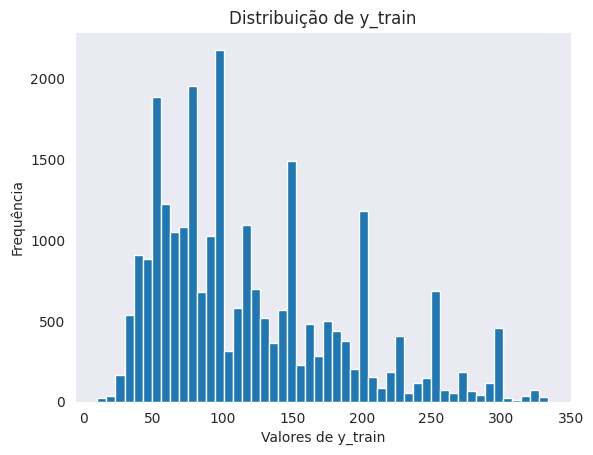

In [70]:
plt.hist(y_train, bins=50)
plt.xlabel("Valores de y_train")
plt.ylabel("Frequência")
plt.title("Distribuição de y_train")
plt.show()


In [71]:
mae = 33.03
erro_relativo = mae / y_train.mean()
print(f"Erro relativo médio: {erro_relativo:.2%}")

Erro relativo médio: 27.59%


Com base nos valores acima o modelo está errando muito, as métricas esta sendo arrastadas pela grande variação do valor de y.

In [72]:
df_treino.corr()

,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,disponibilidade_365,review_recente,bairro_group_Bronx,bairro_group_Brooklyn,bairro_group_Manhattan,bairro_group_Queens,bairro_group_Staten Island,room_Entire home/apt,room_Private room,room_Shared room,bairro_encoded
latitude,1.000000,0.105714,0.059436,-0.013517,-0.015137,-0.023609,-0.041809,-0.036868,0.336673,-0.672307,0.592030,0.024406,-0.189600,-0.013345,0.009201,0.012949,0.025433
longitude,0.105714,1.000000,-0.291451,-0.084473,0.048704,0.102425,0.154534,0.076124,0.224610,-0.012707,-0.404494,0.611920,-0.302122,-0.179641,0.168892,0.032858,-0.038560
price,0.059436,-0.291451,1.000000,0.043099,-0.009609,-0.015838,0.020883,0.010142,-0.097183,-0.174198,0.309472,-0.147332,-0.036746,0.613730,-0.569386,-0.136203,-0.025026
minimo_noites,-0.013517,-0.084473,0.043099,1.000000,-0.043373,-0.132709,-0.062941,-0.044328,-0.039269,0.045492,0.014129,-0.068288,-0.016683,0.146987,-0.125715,-0.066088,0.037095
numero_de_reviews,-0.015137,0.048704,-0.009609,-0.043373,1.000000,0.569750,0.225771,0.445375,0.018634,-0.004479,-0.024597,0.029099,0.023427,0.028269,-0.022835,-0.016930,-0.019700
reviews_por_mes,-0.023609,0.102425,-0.015838,-0.132709,0.569750,1.000000,0.262704,0.688904,0.048025,-0.026084,-0.045306,0.077299,0.033034,0.008244,-0.015245,0.022039,-0.041480
disponibilidade_365,-0.041809,0.154534,0.020883,-0.062941,0.225771,0.262704,1.000000,0.339639,0.092351,-0.043444,-0.089975,0.137899,0.080896,-0.119273,0.092627,0.083109,-0.114832
review_recente,-0.036868,0.076124,0.010142,-0.044328,0.445375,0.688904,0.339639,1.000000,0.038621,-0.008255,-0.049013,0.058207,0.039522,0.025427,-0.031816,0.020201,-0.039425
bairro_group_Bronx,0.336673,0.224610,-0.097183,-0.039269,0.018634,0.048025,0.092351,0.038621,1.000000,-0.139230,-0.130610,-0.057431,-0.013986,-0.057570,0.043829,0.042881,-0.183488
bairro_group_Brooklyn,-0.672307,-0.012707,-0.174198,0.045492,-0.004479,-0.026084,-0.043444,-0.008255,-0.139230,1.000000,-0.738792,-0.324859,-0.079110,-0.052940,0.062511,-0.030338,0.363692


As correlacoes parecem muito baixa de todas varievsi exceto quando -> room_Entire home/apt.  Vamos analisar por meio de um feature importance, para o seguinte testa usaremos o XGBoost ja que po muito pouco, foi melhor que o random forest.

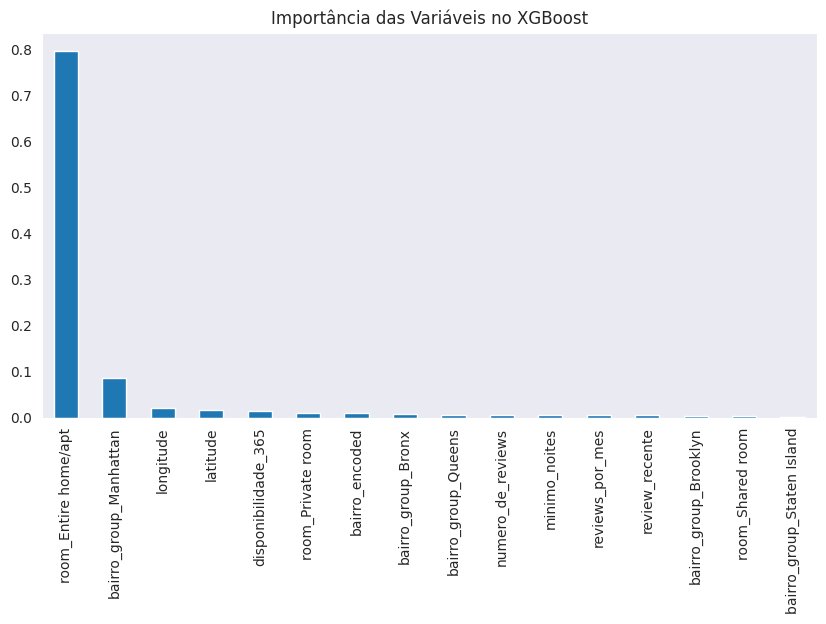

In [73]:
# Treinando um modelo rápido para avaliar a importância das features
modelo = XGBRegressor(n_estimators=100, max_depth=6, learning_rate= 0.1, random_state=42)
modelo.fit(X_train, y_train)

# Pegando a importância das variáveis
importancias = pd.Series(modelo.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plotando
plt.figure(figsize=(10, 5))
importancias.plot(kind='bar')
plt.title("Importância das Variáveis no XGBoost")
plt.show()

Aqui vemos que claramente, alem de room_Entire home/Apt e bairro_group_Manhattan, as outras variaveis apresentam quase ganho nulo. Como ultima tentativa iremos iremos realizar uma transformacao logariitma dos dados.

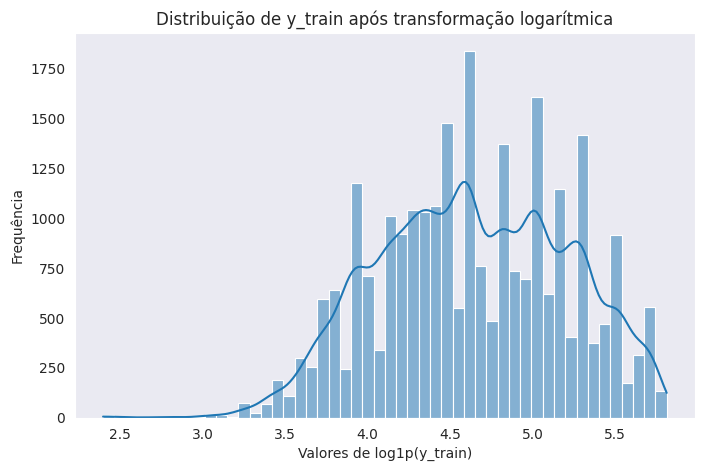

In [74]:
y_train_transf = np.log1p(y_train)
y_test_transf = np.log1p(y_test)  # Se for usar no teste também

plt.figure(figsize=(8, 5))
sns.histplot(y_train_transf, bins=50, kde=True)
plt.xlabel("Valores de log1p(y_train)")
plt.ylabel("Frequência")
plt.title("Distribuição de y_train após transformação logarítmica")
plt.show()


In [75]:
xgb = XGBRegressor(**dict_xgboost, random_state=42)

modelo_log = xgb.fit(X_train, y_train_transf)

y_pred_transf = modelo_log.predict(X_test)
y_pred = np.expm1(y_pred_transf)

mae2 = mean_absolute_error(y_test, y_pred)
rmse2 = np.sqrt(mean_squared_error(y_test, y_pred))
r22 = r2_score(y_test, y_pred)

# y_train_transf y_test_transf

print(f"  MAE_log: {mae2:.2f}")
print(f"  RMSE_log: {rmse2:.2f}")
print(f"  R²_log: {r22:.4f}")
print("-__________________________________________-" )
#print(f"mae {mae2} | rmse {rmse2} || r2 {r22}")

  MAE_log: 32.52
  RMSE_log: 46.28
  R²_log: 0.5341
-__________________________________________-


Mesmo usando logaritmo na variável de saída, os resultados obtidos não foram melhores. Então usaremos o melhor modelo de XGBoost, mesmo este tendo um resultado final muito aquém do esperado, foi o que melhor performou.

## Prevendo novo registro

In [76]:
#Modelo final
xgb_fim = XGBRegressor(**dict_xgboost, random_state=42)
modelo_fim = xgb_fim.fit(X_train, y_train)



In [77]:
novo_exemplo = pd.DataFrame([{'id': 2595,
 'nome': 'Skylit Midtown Castle',
 'host_id': 2845,
 'host_name': 'Jennifer',
 'bairro_group': 'Manhattan',
 'bairro': 'Midtown',
 'latitude': 40.75362,
 'longitude': -73.98377,
 'room_type': 'Entire home/apt',
 'minimo_noites': 1,
 'numero_de_reviews': 45,
 'ultima_review': '2019-05-21',
 'reviews_por_mes': 0.38,
 'calculado_host_listings_count': 2,
 'disponibilidade_365': 355}
])


In [78]:
def transformar_dados(novo_exemplo, X_train_columns):
    # Copia pa nao dar mais problema
    df = novo_exemplo.copy()


    df.drop(columns=['id', 'nome', 'host_id', 'host_name'], inplace=True)

    bairros_group = ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']
    for bairro in bairros_group:
        df[f'bairro_group_{bairro}'] = (df['bairro_group'] == bairro)
    df.drop(columns=['bairro_group'], inplace=True)

    room_types = ['Entire home/apt', 'Private room', 'Shared room']
    for room in room_types:
        df[f'room_{room}'] = (df['room_type'] == room)
    df.drop(columns=['room_type'], inplace=True)

    df['ultima_review'] = pd.to_datetime(df['ultima_review'], errors='coerce')
    df['review_recente'] = df['ultima_review'].notna()
    df.drop(columns=['ultima_review'], inplace=True)


    df['bairro_encoded'] = np.random.rand(len(df))


    for col in X_train_columns:
        if col not in df.columns:
            df[col] = False  # caso seja uma variável dummy

    df = df[X_train_columns]

    return df


X_train_columns = X_train.columns
novo_exemplo_transformado = transformar_dados(novo_exemplo, X_train_columns)
novo_exemplo_transformado

   latitude  longitude  minimo_noites  numero_de_reviews  reviews_por_mes  \
0  40.75362  -73.98377              1                 45             0.38   

   disponibilidade_365  review_recente  bairro_group_Bronx  \
0                  355            True               False   

   bairro_group_Brooklyn  bairro_group_Manhattan  bairro_group_Queens  \
0                  False                    True                False   

   bairro_group_Staten Island  room_Entire home/apt  room_Private room  \
0                       False                  True              False   

   room_Shared room  bairro_encoded  
0             False        0.034641  


In [79]:
previsao = xgb_fim.predict(novo_exemplo_transformado)
previsao

array([225.54056], dtype=float32)

Apesar de nosso modelo não conseguir captar os padrões dos dados, neste registro ele obteve um resultado muito bom, afinal este registro é bem semelhante ao primeiro da base, que continha price como 225.

In [ ]:
#Salvando o modelo

In [80]:
import joblib

# Salvar o modelo em .pkl
joblib.dump(modelo_fim, 'modelo_fim.pkl')


['modelo_fim.pkl']